In [1]:
%config Completer.use_jedi = False

import argparse
import pandas as pd
import rdkit
from rdkit import Chem, Geometry
from rdkit.Chem import AllChem, rdFMCS, DataStructs, Draw
import os
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from spyrmsd.molecule import Molecule
from spyrmsd.rmsd import rmsdwrapper
import multiprocessing
from tqdm import tqdm

def get_tanimoto_similarity(row):
    ligand = row['Docked']
    # Assuming that Template is somehow related to Ligand
    # For example, if templates correspond to ligands directly:
    template = row['Template']
    # Here we would retrieve the similarity based on the Ligand
    # Assuming we want to compare each Ligand with all Ligands and store the score
    # The following just returns the similarity of the Ligand with itself
    try:
        ts = similarity_matrix.loc[ligand, template]
    except:
        ts = None
    return ts


def get_mcs_conf(mol, matches, mcs):
    # Create a new molecule with selected atoms and their bonds
    new_mol = Chem.RWMol()

#     matches = mol.GetSubstructMatch(mcs)
    # Add atoms and bonds to the editable molecule
    atom_mapping = {}  # To keep track of the mapping between old and new atom indices
    for atom_idx in matches:
        old_atom = mol.GetAtomWithIdx(atom_idx)
        new_atom_idx = new_mol.AddAtom(old_atom)
        atom_mapping[atom_idx] = new_atom_idx


    for bond in mol.GetBonds():
        if bond.GetBeginAtomIdx() in matches and bond.GetEndAtomIdx() in matches:
            # Add the bond if both atoms are in the selected list
            new_mol.AddBond(atom_mapping[bond.GetBeginAtomIdx()],
                            atom_mapping[bond.GetEndAtomIdx()],
                            bond.GetBondType())


    # Convert the editable molecule to a new molecule object
    new_mol = new_mol.GetMol()
#     Chem.SanitizeMol(new_mol)

    conf = mol.GetConformer()

    coords = []
    for s in matches:
        coords.append(tuple(conf.GetAtomPosition(s)))

    new_conf = Chem.Conformer(new_mol.GetNumAtoms())
    for i,(x,y,z) in enumerate(coords):
        new_conf.SetAtomPosition(i,Geometry.Point3D(x,y,z))

    new_conf.Set3D(False)
    new_mol.AddConformer(new_conf)

    return new_mol


def get_rmsd(ref, mol):
    d = Molecule.from_rdkit(ref)
    t = Molecule.from_rdkit(mol)

    rmsd = round(float(rmsdwrapper(d, t)[0]), 3)

    return rmsd


def get_sub_rmsd(dock, temp, mcs):

    dock_matches = dock.GetSubstructMatches(mcs)
    temp_matches = temp.GetSubstructMatches(mcs)

    dock_confs = []
    for dock_match in dock_matches:
        dock_confs.append(get_mcs_conf(dock, dock_match, mcs))

    temp_confs = []
    for temp_match in temp_matches:
        temp_confs.append(get_mcs_conf(temp, temp_match, mcs))

    dock_spy = [Molecule.from_rdkit(dock_conf) for dock_conf in dock_confs]
    temp_spy = [Molecule.from_rdkit(temp_conf) for temp_conf in temp_confs]

    rmsds = []
    for d in dock_spy:
        for t in temp_spy:
            rmsds.append(round(float(rmsdwrapper(d, t)[0]), 3))

    return min(rmsds)


def fix_connectivity(mol1, mol2, mcs):
    
    mol1_matches = mol1.GetSubstructMatches(mcs)
    mol2_matches = mol2.GetSubstructMatches(mcs)

    mol1_confs = []
    for mol1_match in mol1_matches:
        mol1_confs.append(get_mcs_mol(mol1, mol1_match, mcs))

    mol2_confs = []
    for mol2_match in mol2_matches:
        mol2_confs.append(get_mcs_mol(mol2, mol2_match, mcs))
    
    mol1_conf = mol1_confs[0]
    mol2_conf = mol2_confs[0]
    
    to_remove = []
    for i in range(mcs.GetNumAtoms()):

        mol1_atom = mol1_conf.GetAtomWithIdx(i)
        mol2_atom = mol2_conf.GetAtomWithIdx(i)

        if mol1_atom.GetSymbol() == mol2_atom.GetSymbol():
            if not len(mol1_atom.GetNeighbors()) == len(mol2_atom.GetNeighbors()):
                to_remove.append(i)
    if to_remove:
        new_mcs = Chem.EditableMol(mcs)
        for i in reversed(to_remove):
            new_mcs.RemoveAtom(i)
            
        return new_mcs.GetMol()

    
def check_fragments(mol):
    
    frags = Chem.GetMolFrags(mol, asMols=True, sanitizeFrags=False)
    size = []
    for frag in frags:
        size.append(frag.GetNumAtoms())
    updated_mcs = frags[size.index(max(size))]
    
    return updated_mcs


def get_mcs_mol(mol, matches, mcs):
    # Create a new molecule with selected atoms and their bonds
    new_mol = Chem.RWMol()

#     matches = mol.GetSubstructMatch(mcs)
    # Add atoms and bonds to the editable molecule
    atom_mapping = {}  # To keep track of the mapping between old and new atom indices
    for atom_idx in matches:
        old_atom = mol.GetAtomWithIdx(atom_idx)
        new_atom_idx = new_mol.AddAtom(old_atom)
        atom_mapping[atom_idx] = new_atom_idx


    for bond in mol.GetBonds():
        if bond.GetBeginAtomIdx() in matches and bond.GetEndAtomIdx() in matches:
            # Add the bond if both atoms are in the selected list
            new_mol.AddBond(atom_mapping[bond.GetBeginAtomIdx()],
                            atom_mapping[bond.GetEndAtomIdx()],
                            bond.GetBondType())

    new_mol = new_mol.GetMol()

    return new_mol


In [2]:
astex = pd.read_csv('../data/astex_selected_for_docking.csv', usecols=['UniProt_ID', 'PDB', 'Lig', 'Smiles_String'])
astex['Template'] = astex['PDB'] + '_' + astex['Lig']
astex = astex[astex.UniProt_ID != 'P04818']

astex 

,UniProt_ID,PDB,Lig,Smiles_String,Template
0,O14757,3TKH,07S,c1cc(cnc1)c2cnc(s2)Nc3cc(ccn3)N4CCN(CC4)CC(=O)...,3TKH_07S
1,O14757,4HYH,1AM,COc1ccc2c(c1)C(=O)N(C2)c3nc(cs3)C(=O)Nc4cnccc4...,4HYH_1AM
2,O14757,4HYI,1AO,c1ccc2c(c1)cnn2c3nc(cs3)C(=O)Nc4ccccc4N5CCNCC5,4HYI_1AO
3,O14757,4JIK,1KO,c1cc(ccc1c2cn3c(n2)c(cnc3C(=O)N)N[C@H]4CCCNC4)Cl,4JIK_1KO
4,O14757,3OT3,22K,Cn1cc(cn1)c2cnn3c2nc(c(c3N)Br)[C@@H]4CCC[C@@H]...,3OT3_22K
...,...,...,...,...,...
2005,Q8I3X4,1Q1G,MTI,CSC[C@@H]1[C@H]([C@H]([C@@H]([NH2+]1)c2c[nH]c3...,1Q1G_MTI
2006,Q9GPQ4,1HP0,AD3,c1cnc(c2c1n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)C...,1HP0_AD3
2007,Q9GPQ4,3B9G,IMH,c1c(c2c([nH]1)c(ncn2)O)[C@H]3[C@@H]([C@@H]([C@...,3B9G_IMH
2008,Q9GPQ4,3EPX,IMQ,c1cc2cccnc2c(c1)C[N@]3C[C@@H]([C@@H]([C@H]3CO)O)O,3EPX_IMQ


# Ligand number per target

In [3]:
from rdkit.Chem import Descriptors, rdFreeSASA
from rdkit.Chem import Crippen, rdMolDescriptors


def assign_radii(mol):
    radii = []
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() == 1:  # Hydrogen
            radii.append(1.2)
        elif atom.GetAtomicNum() == 6:  # Carbon
            radii.append(1.7)
        elif atom.GetAtomicNum() == 7:  # Nitrogen
            radii.append(1.55)
        elif atom.GetAtomicNum() == 8:  # Oxygen
            radii.append(1.52)
        else:  # Default radius for unknown atoms
            radii.append(1.8)
    return radii


def calculate_sasa(mol):
    if mol is None:
        return None
    # Assign radii
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())
    AllChem.UFFOptimizeMolecule(mol)  # Optimize geometry

    # Assign radii manually
    radii = assign_radii(mol)
    total_sasa = rdFreeSASA.CalcSASA(mol, radii)
    
    return total_sasa

In [6]:
if os.path.exists('../data/similarity_matrix.csv'):
    similarity_matrix = pd.read_csv('../data/similarity_matrix.csv')
    similarity_matrix.index = similarity_matrix.columns
else:
    print('Similarity matrix not found')
    # Calculate simiarity matrix
    temp_smi_dict = dict(zip(astex.Template, astex.Smiles_String))
    mol_dict = {name: Chem.MolFromSmiles(smiles) for name, smiles in temp_smi_dict.items()}
    fp_dict = {name: AllChem.GetMorganGenerator(radius=2, fpSize=2048).GetFingerprint(mol) for name, mol in mol_dict.items() if mol is not None}

    ligand_names = list(fp_dict.keys())

    similarity_matrix = pd.DataFrame(index=ligand_names, columns=ligand_names)
    for ligand1 in tqdm(ligand_names):
        for ligand2 in ligand_names:
            sim = DataStructs.TanimotoSimilarity(fp_dict[ligand1], fp_dict[ligand2])
            similarity_matrix.loc[ligand1, ligand2] = sim

    similarity_matrix.to_csv('../data/similarity_matrix.csv', index=True)


In [7]:
temp_smi_dict = dict(zip(astex.Template, astex.Smiles_String))
mol_dict = {name: Chem.MolFromSmiles(smiles) for name, smiles in temp_smi_dict.items()}
fp_dict = {name: AllChem.GetMorganGenerator(radius=2, fpSize=2048).GetFingerprint(mol) for name, mol in mol_dict.items() if mol is not None}

ligand_names = list(fp_dict.keys())

clean_astex = astex[astex['Template'].isin(ligand_names)]

uniprots = astex.UniProt_ID.unique()

count_df = astex.groupby('UniProt_ID').size().reset_index(name='count')
count_df

[23:35:01] Explicit valence for atom # 7 Cl, 5, is greater than permitted
[23:35:01] Explicit valence for atom # 35 O, 2, is greater than permitted


,UniProt_ID,count
0,O14757,73
1,O43570,12
2,O76074,17
3,P00183,3
4,P00374,22
...,...,...
66,Q24451,30
67,Q54276,5
68,Q79MP6,2
69,Q8I3X4,3


In [8]:
astex_props = clean_astex.copy()

In [9]:
astex_props = astex_props[['UniProt_ID', 'Template', 'Smiles_String']].reset_index()

astex_props['Mol'] = astex_props['Smiles_String'].apply(Chem.MolFromSmiles)
astex_props['MolWt'] = astex_props['Mol'].apply(Descriptors.MolWt)
astex_props['LogP'] = astex_props['Mol'].apply(Crippen.MolLogP)
astex_props['RotBonds'] = astex_props['Mol'].apply(Descriptors.NumRotatableBonds)
astex_props['HBA'] = astex_props['Mol'].apply(Descriptors.NumHAcceptors)
astex_props['HBD'] = astex_props['Mol'].apply(Descriptors.NumHDonors)
astex_props['TotSASA'] = astex_props['Mol'].apply(lambda mol: calculate_sasa(mol) if mol else None)

[23:35:48] UFFTYPER: Unrecognized atom type: S_5+4 (19)
[23:35:48] UFFTYPER: Unrecognized atom type: S_5+4 (19)
[23:35:48] UFFTYPER: Unrecognized atom type: S_5+4 (19)
[23:35:48] UFFTYPER: Unrecognized atom type: S_5+4 (19)
[23:35:50] UFFTYPER: Unrecognized atom type: Se2+2 (10)
[23:35:51] UFFTYPER: Unrecognized atom type: Se2+2 (10)
[23:37:28] UFFTYPER: Unrecognized charge state for atom: 7
[23:37:28] UFFTYPER: Unrecognized charge state for atom: 7
[23:37:28] UFFTYPER: Unrecognized charge state for atom: 3
[23:37:28] UFFTYPER: Unrecognized charge state for atom: 3


In [10]:
astex_props

,index,UniProt_ID,Template,Smiles_String,Mol,MolWt,LogP,RotBonds,HBA,HBD,TotSASA
0,0,O14757,3TKH_07S,c1cc(cnc1)c2cnc(s2)Nc3cc(ccn3)N4CCN(CC4)CC(=O)...,<rdkit.Chem.rdchem.Mol object at 0x7160c47df370>,465.583,2.3245,6,9,1,785.075929
1,1,O14757,4HYH_1AM,COc1ccc2c(c1)C(=O)N(C2)c3nc(cs3)C(=O)Nc4cnccc4...,<rdkit.Chem.rdchem.Mol object at 0x7160c47df300>,450.524,2.3690,5,8,2,725.954647
2,2,O14757,4HYI_1AO,c1ccc2c(c1)cnn2c3nc(cs3)C(=O)Nc4ccccc4N5CCNCC5,<rdkit.Chem.rdchem.Mol object at 0x7160c47df290>,404.499,3.1439,4,7,2,671.987720
3,3,O14757,4JIK_1KO,c1cc(ccc1c2cn3c(n2)c(cnc3C(=O)N)N[C@H]4CCCNC4)Cl,<rdkit.Chem.rdchem.Mol object at 0x7160c47df220>,370.844,2.3125,4,6,3,624.016595
4,4,O14757,3OT3_22K,Cn1cc(cn1)c2cnn3c2nc(c(c3N)Br)[C@@H]4CCC[C@@H]...,<rdkit.Chem.rdchem.Mol object at 0x7160c47df1b0>,390.289,2.4594,2,7,2,576.090406
...,...,...,...,...,...,...,...,...,...,...,...
2002,2005,Q8I3X4,1Q1G_MTI,CSC[C@@H]1[C@H]([C@H]([C@@H]([NH2+]1)c2c[nH]c3...,<rdkit.Chem.rdchem.Mol object at 0x7160c24006d0>,297.360,-1.6773,3,5,5,498.641004
2003,2006,Q9GPQ4,1HP0_AD3,c1cnc(c2c1n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)C...,<rdkit.Chem.rdchem.Mol object at 0x7160c2400740>,266.257,-1.3750,2,8,4,455.910592
2004,2007,Q9GPQ4,3B9G_IMH,c1c(c2c([nH]1)c(ncn2)O)[C@H]3[C@@H]([C@@H]([C@...,<rdkit.Chem.rdchem.Mol object at 0x7160c24007b0>,266.257,-1.6095,2,7,6,460.729375
2005,2008,Q9GPQ4,3EPX_IMQ,c1cc2cccnc2c(c1)C[N@]3C[C@@H]([C@@H]([C@H]3CO)O)O,<rdkit.Chem.rdchem.Mol object at 0x7160c2400820>,274.320,0.1331,3,5,3,491.126009


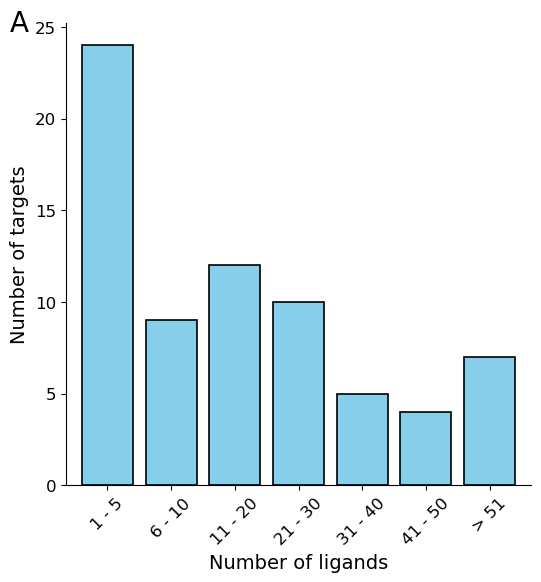

In [11]:
plt.figure(figsize=(6, 6))
# bins = list(range(1, 101, 10)) + [float('inf')]
bins = [0, 5, 10, 20, 30, 40, 50, float('inf')]
labels = [f"{bins[i]+1} - {bins[i+1]}" if bins[i+1] != float('inf') else f"> {bins[i]+1}" for i in range(len(bins)-1)]

# Categorize data using pd.cut
count_df['group'] = pd.cut(count_df['count'], bins=bins, labels=labels, right=True)

lig_counts = count_df['group'].value_counts(sort=False)

lig_counts.plot(kind='bar', color='skyblue', edgecolor='black', width=0.8, linewidth=1.2)
# plt.grid(False)

plt.xlabel('Number of ligands', fontsize=14)
plt.ylabel('Number of targets', fontsize=14)

plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.text(-0.1, 1, 'A', fontsize=20, ha='center', va='center', transform=plt.gca().transAxes)


# plt.tight_layout()
plt.savefig('../images/ligand_properties/number_of_ligands.png', 
            dpi=300,
            bbox_inches='tight')
plt.show()

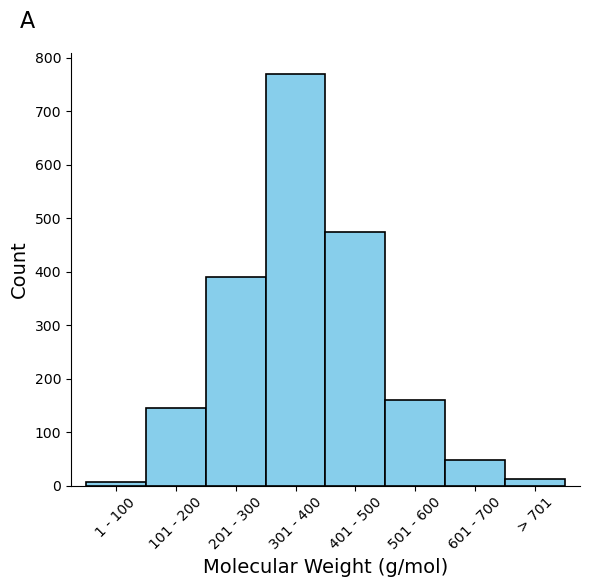

In [12]:
plt.figure(figsize=(6,6))
bins = list(range(1, 801, 100)) + [float('inf')]

labels = [f"{bins[i]} - {bins[i+1]-1}" if bins[i+1] != float('inf') else f"> {bins[i]}" for i in range(len(bins)-1)]

astex_props['wt_group'] = pd.cut(astex_props['MolWt'], bins=bins[:-1] + [float('inf')], labels=labels, right=True)
wt_counts = astex_props['wt_group'].value_counts(sort=False)

wt_counts.plot(kind='bar', color='skyblue', edgecolor='black', width=1, linewidth=1.2)
# plt.hist(astex_props['MolWt'], bins=bins, color='skyblue', edgecolor='black', linewidth=1.2)

plt.grid(False)
plt.xlabel('Molecular Weight (g/mol)', fontsize=14)
plt.text(-0.1, 1.1, 'A', fontsize=16, ha='left', va='top', transform=plt.gca().transAxes)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')

plt.tight_layout()

plt.savefig('../images/ligand_properties/moleuclar_weight.png', dpi=300)
plt.show()

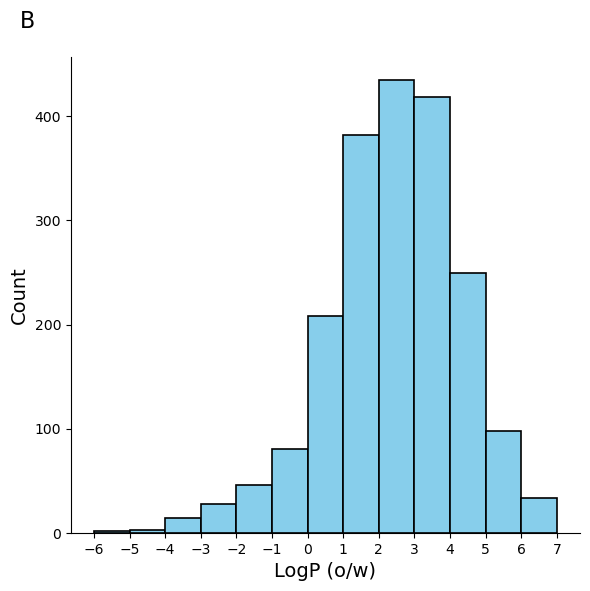

In [13]:
plt.figure(figsize=(6,6))
bins = list(range(-6, 8, 1))

# labels = [f"{bins[i]} to {bins[i+1]-0.1}" if bins[i+1] != float('inf') else f">{bins[i]}" for i in range(len(bins)-1)]

# astex_props['logp_group'] = pd.cut(astex_props['LogP'], bins=bins[:-1] + [float('inf')], labels=labels, right=True)
# logp_counts = astex_props['logp_group'].value_counts(sort=False)

# logp_counts.plot(kind='bar', color='skyblue', edgecolor='black', width=1, linewidth=1.2)
plt.hist(astex_props['LogP'], color='skyblue', bins=bins, edgecolor='black', linewidth=1.2)
plt.grid(False)
# plt.axvline(x=5.5, color='red', linestyle='-')
plt.xlabel('LogP (o/w)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.text(-0.1, 1.1, 'B', fontsize=16, ha='left', va='top', transform=plt.gca().transAxes)
plt.xticks(range(-6,8,1))

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')

plt.tight_layout()

plt.savefig('../images/ligand_properties/LogP.png', dpi=300)
plt.show()

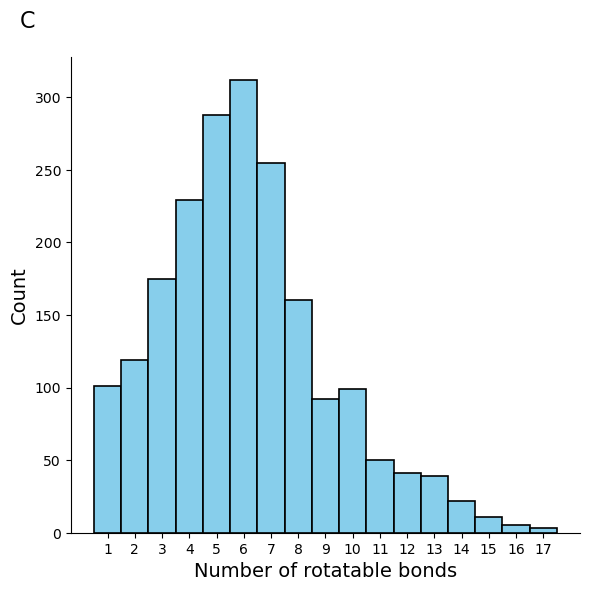

In [14]:
plt.figure(figsize=(6,6))
bins = range(0,18,1)
plt.hist(astex_props['RotBonds'], bins=bins, color='skyblue', align='right', edgecolor='black', linewidth=1.2)
plt.grid(False)

plt.xlabel('Number of rotatable bonds', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(range(1, 18))
plt.text(-0.1, 1.1, 'C', fontsize=16, ha='left', va='top', transform=plt.gca().transAxes)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')

plt.tight_layout()


plt.savefig('../images/ligand_properties/rotatable_bonds.png', dpi=300)
plt.show()

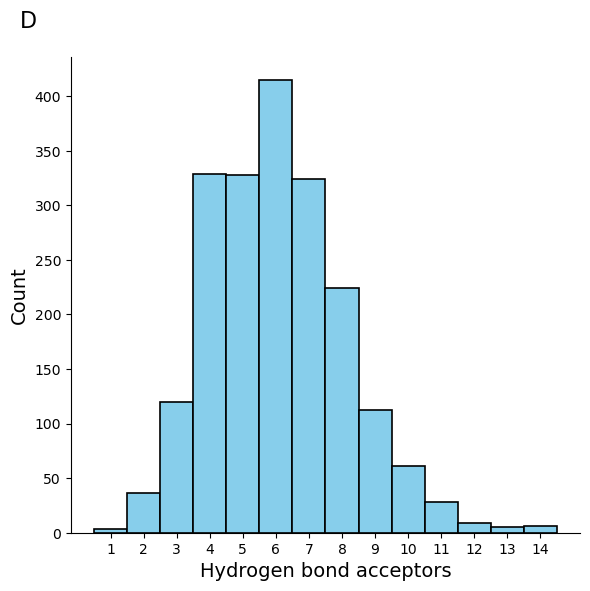

In [15]:
plt.figure(figsize=(6,6))
bins = range(0,15,1)
plt.hist(astex_props['HBA'],bins=bins, color='skyblue', align='right', edgecolor='black', width=1, linewidth=1.2)
plt.grid(False)

plt.xlabel('Hydrogen bond acceptors', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(range(1,15,1))
plt.text(-0.1, 1.1, 'D', fontsize=16, ha='left', va='top', transform=plt.gca().transAxes)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')

plt.tight_layout()


plt.savefig('../images/ligand_properties/HBA.png', dpi=300)
plt.show()

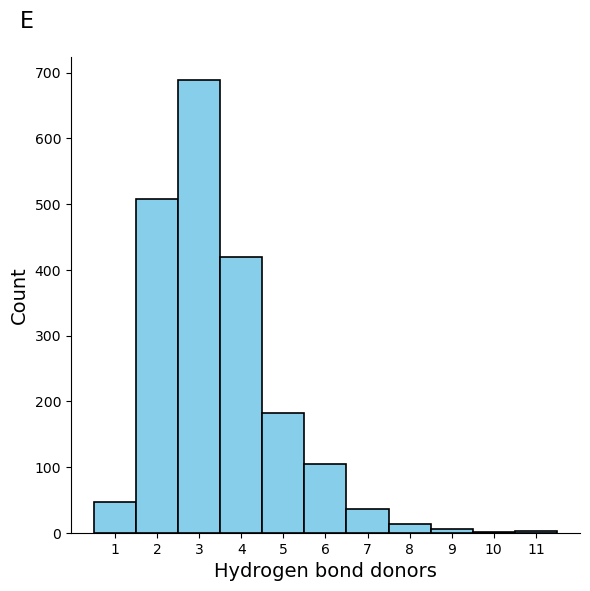

In [16]:
plt.figure(figsize=(6,6))
bins = range(0,12,1)
plt.hist(astex_props['HBD'], bins=bins, color='skyblue',align='right', edgecolor='black', linewidth=1.2)
plt.grid(False)

plt.xlabel('Hydrogen bond donors', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.text(-0.1, 1.1, 'E', fontsize=16, ha='left', va='top', transform=plt.gca().transAxes)
plt.xticks(range(1,12,1))

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')

plt.tight_layout()

plt.savefig('../images/ligand_properties/HBD.png', dpi=300)
plt.show()

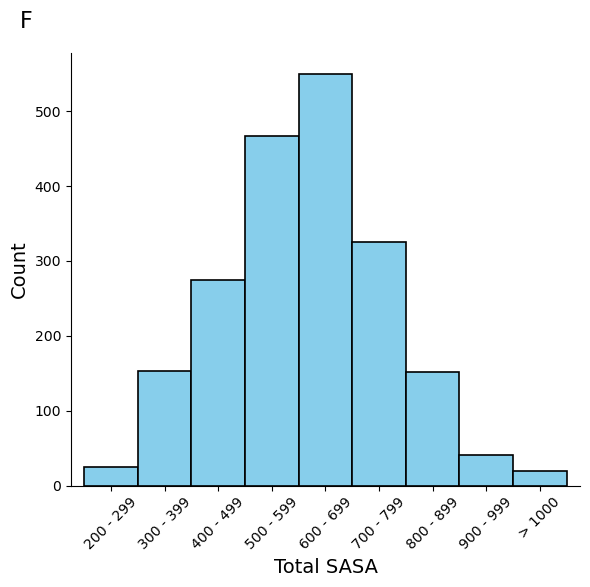

In [52]:
plt.figure(figsize=(6,6))

bins = list(range(200, 1100, 100)) + [float('inf')]

labels = [f"{bins[i]} - {bins[i+1]-1}" if bins[i+1] != float('inf') else f"> {bins[i]}" for i in range(len(bins)-1)]

astex_props['sasa_group'] = pd.cut(astex_props['TotSASA'], bins=bins[:-1] + [float('inf')], labels=labels, right=True)
wt_counts = astex_props['sasa_group'].value_counts(sort=False)

wt_counts.plot(kind='bar', color='skyblue', edgecolor='black', width=1, linewidth=1.2)



# plt.hist(astex_props['TotSASA'], bins=bins, color='skyblue', edgecolor='black', linewidth=1.2)
plt.grid(False)

plt.xlabel('Total SASA', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.text(-0.1, 1.1, 'F', fontsize=16, ha='left', va='top', transform=plt.gca().transAxes)
plt.xticks(rotation=45)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')

plt.tight_layout()

plt.savefig('../images/ligand_properties/SASA.png', dpi=300)
plt.show()

# MCS RMSD analysis

In [18]:
similarity_matrix

,3TKH_07S,4HYH_1AM,4HYI_1AO,4JIK_1KO,3OT3_22K,2HY0_306,2HXQ_373,2CGU_3A3,2CGW_3C3,2CGX_3D3,...,1W1Y_TYP,1JJT_BDS,1JJE_BYS,6AQS_IM5,1NW4_IMH,1Q1G_MTI,1HP0_AD3,3B9G_IMH,3EPX_IMQ,3EPW_JMQ
3TKH_07S,1.000000,0.163636,0.151515,0.135922,0.067961,0.130000,0.110000,0.109756,0.067416,0.090909,...,0.137931,0.137500,0.144578,0.103093,0.087912,0.082474,0.134831,0.087912,0.147727,0.105263
4HYH_1AM,0.163636,1.000000,0.463415,0.160377,0.094340,0.155340,0.125000,0.141176,0.097826,0.096774,...,0.141304,0.089888,0.086022,0.130000,0.060606,0.088235,0.091837,0.060606,0.114583,0.110000
4HYI_1AO,0.151515,0.463415,1.000000,0.197802,0.108696,0.129032,0.144444,0.077922,0.087500,0.113924,...,0.151899,0.106667,0.129870,0.151163,0.070588,0.065934,0.107143,0.070588,0.148148,0.114943
4JIK_1KO,0.135922,0.160377,0.197802,1.000000,0.166667,0.148936,0.115789,0.088608,0.071429,0.151899,...,0.132530,0.088608,0.084337,0.120879,0.093023,0.086957,0.103448,0.093023,0.116279,0.111111
3OT3_22K,0.067961,0.094340,0.108696,0.166667,1.000000,0.109890,0.100000,0.039474,0.106667,0.076923,...,0.087500,0.039474,0.037500,0.104651,0.048193,0.056818,0.098765,0.048193,0.085366,0.068966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1Q1G_MTI,0.082474,0.088235,0.065934,0.086957,0.056818,0.103448,0.093023,0.104478,0.068493,0.144928,...,0.108108,0.072464,0.068493,0.232877,0.281250,1.000000,0.135135,0.281250,0.135135,0.375000
1HP0_AD3,0.134831,0.091837,0.107143,0.103448,0.098765,0.069767,0.084337,0.093750,0.104478,0.136364,...,0.098592,0.111111,0.104478,0.178082,0.181818,0.135135,1.000000,0.181818,0.230769,0.183099
3B9G_IMH,0.087912,0.060606,0.070588,0.093023,0.048193,0.084337,0.086420,0.096774,0.058824,0.158730,...,0.101449,0.062500,0.058824,0.217391,1.000000,0.281250,0.181818,1.000000,0.181818,0.261538
3EPX_IMQ,0.147727,0.114583,0.148148,0.116279,0.085366,0.135802,0.153846,0.111111,0.072464,0.102941,...,0.114286,0.111111,0.121212,0.264706,0.181818,0.135135,0.230769,0.181818,1.000000,0.473684


In [14]:
reference_rmsd = []

REFERENCE_LIGANDS = 'reference_ligands/'

if not os.path.exists(REFERENCE_LIGANDS): 
    print('Download reference ligands at: https://doi.org/10.5281/zenodo.15779718')
    print('or jump to next cell and load the file')

for uni in astex.UniProt_ID.unique():
    
    target_df = astex[astex.UniProt_ID == uni]
    
    for lig1 in tqdm(target_df.Template, total=len(target_df)):
#         print(lig1)
        mol1 = Chem.SDMolSupplier(f'{REFERENCE_LIGANDS}/{uni}/{lig1}.sdf')[0]
        
        for lig2 in target_df.Template:
            
            rmsd = None
            
            mol2 = Chem.SDMolSupplier(f'{REFERENCE_LIGANDS}/{uni}/{lig2}.sdf')[0]

            soft_mcs = Chem.MolFromSmarts(rdFMCS.FindMCS([mol1,mol2],
                              atomCompare=rdFMCS.AtomCompare.CompareElements,
                              bondCompare=rdFMCS.BondCompare.CompareOrderExact,
                              ringMatchesRingOnly=False,
                              timeout=1).smartsString)
            try:
                rmsd = get_sub_rmsd(mol1, mol2, soft_mcs)
            except Exception as e:
            #     print(e)
                if 'Graphs are not isomorphic' in str(e):
                    try:
                        updated_mcs = fix_connectivity(mol1, mol2, soft_mcs)
                        if len(Chem.GetMolFrags(updated_mcs, asMols=True, sanitizeFrags=False)) >=2:
                            updated_mcs = check_fragments(updated_mcs)

                        rmsd = get_sub_rmsd(mol1, mol2, updated_mcs)
                    except Exception as e2:
                        continue
                        
            reference_rmsd.append({'UniProtID': uni,
                                   'Template': lig1,
                                   'Docked': lig2,
                                   'rmsd': rmsd})

  1%|▌                                           | 1/73 [00:01<01:42,  1.43s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


  3%|█▏                                          | 2/73 [00:02<01:21,  1.15s/it]

Problematic
Problematic


  4%|█▊                                          | 3/73 [00:03<01:20,  1.15s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


  5%|██▍                                         | 4/73 [00:04<01:12,  1.05s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


  7%|███                                         | 5/73 [00:05<01:17,  1.15s/it]

Problematic
Problematic
Problematic
Problematic


  8%|███▌                                        | 6/73 [00:09<02:09,  1.93s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 10%|████▏                                       | 7/73 [00:12<02:27,  2.23s/it]

Problematic
Problematic


 12%|█████▍                                      | 9/73 [00:13<01:33,  1.46s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 14%|█████▉                                     | 10/73 [00:14<01:14,  1.19s/it]

Problematic
Problematic


 15%|██████▍                                    | 11/73 [00:15<01:07,  1.09s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 16%|███████                                    | 12/73 [00:17<01:36,  1.58s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 18%|███████▋                                   | 13/73 [00:20<01:55,  1.92s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 19%|████████▏                                  | 14/73 [00:22<01:48,  1.83s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 21%|████████▊                                  | 15/73 [00:25<02:18,  2.38s/it]

Problematic
Problematic
Problematic


 22%|█████████▍                                 | 16/73 [00:27<02:04,  2.18s/it]

Problematic
Problematic
Problematic


 23%|██████████                                 | 17/73 [00:29<01:50,  1.97s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 25%|██████████▌                                | 18/73 [00:31<02:01,  2.21s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 26%|███████████▏                               | 19/73 [00:32<01:39,  1.84s/it]

Problematic


 27%|███████████▊                               | 20/73 [00:33<01:22,  1.56s/it]

Problematic
Problematic
Problematic
Problematic


 29%|████████████▎                              | 21/73 [00:34<01:14,  1.43s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 30%|████████████▉                              | 22/73 [00:36<01:12,  1.42s/it]

Problematic
Problematic
Problematic
Problematic


 32%|█████████████▌                             | 23/73 [00:37<01:03,  1.27s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 33%|██████████████▏                            | 24/73 [00:39<01:11,  1.46s/it]

Problematic
Problematic
Problematic


 34%|██████████████▋                            | 25/73 [00:39<00:59,  1.24s/it]

Problematic
Problematic
Problematic
Problematic


 36%|███████████████▎                           | 26/73 [00:41<01:08,  1.45s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 37%|███████████████▉                           | 27/73 [00:44<01:19,  1.73s/it]

Problematic
Problematic
Problematic
Problematic


 40%|█████████████████                          | 29/73 [00:45<00:56,  1.28s/it]

Problematic
Problematic
Problematic


 41%|█████████████████▋                         | 30/73 [00:46<00:48,  1.13s/it]

Problematic
Problematic


 42%|██████████████████▎                        | 31/73 [00:48<00:51,  1.21s/it]

Problematic
Problematic
Problematic
Problematic


 44%|██████████████████▊                        | 32/73 [00:48<00:46,  1.13s/it]

Problematic
Problematic
Problematic


 45%|███████████████████▍                       | 33/73 [00:50<00:44,  1.12s/it]

Problematic
Problematic


 47%|████████████████████                       | 34/73 [00:51<00:42,  1.10s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 48%|████████████████████▌                      | 35/73 [00:52<00:43,  1.14s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 49%|█████████████████████▏                     | 36/73 [00:54<00:55,  1.50s/it]

Problematic


 51%|█████████████████████▊                     | 37/73 [00:55<00:46,  1.30s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 53%|██████████████████████▉                    | 39/73 [00:57<00:36,  1.06s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 55%|███████████████████████▌                   | 40/73 [00:58<00:34,  1.04s/it]

Problematic
Problematic


 56%|████████████████████████▏                  | 41/73 [00:59<00:35,  1.10s/it]

Problematic
Problematic


 58%|████████████████████████▋                  | 42/73 [01:00<00:33,  1.07s/it]

Problematic
Problematic


 59%|█████████████████████████▎                 | 43/73 [01:01<00:28,  1.06it/s]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 60%|█████████████████████████▉                 | 44/73 [01:02<00:31,  1.07s/it]

Problematic


 62%|██████████████████████████▌                | 45/73 [01:03<00:28,  1.01s/it]

Problematic


 63%|███████████████████████████                | 46/73 [01:04<00:27,  1.00s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 64%|███████████████████████████▋               | 47/73 [01:05<00:28,  1.08s/it]

Problematic


 66%|████████████████████████████▎              | 48/73 [01:07<00:30,  1.20s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 67%|████████████████████████████▊              | 49/73 [01:09<00:38,  1.60s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 68%|█████████████████████████████▍             | 50/73 [01:10<00:34,  1.51s/it]

Problematic
Problematic


 70%|██████████████████████████████             | 51/73 [01:12<00:30,  1.41s/it]

Problematic


 71%|██████████████████████████████▋            | 52/73 [01:12<00:26,  1.25s/it]

Problematic


 73%|███████████████████████████████▏           | 53/73 [01:14<00:24,  1.24s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 74%|███████████████████████████████▊           | 54/73 [01:16<00:32,  1.71s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 75%|████████████████████████████████▍          | 55/73 [01:18<00:28,  1.60s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 77%|████████████████████████████████▉          | 56/73 [01:22<00:39,  2.33s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 78%|█████████████████████████████████▌         | 57/73 [01:25<00:40,  2.50s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 79%|██████████████████████████████████▏        | 58/73 [01:26<00:30,  2.05s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 81%|██████████████████████████████████▊        | 59/73 [01:28<00:27,  1.98s/it]

Problematic
Problematic
Problematic


 82%|███████████████████████████████████▎       | 60/73 [01:29<00:24,  1.87s/it]

Problematic


 86%|█████████████████████████████████████      | 63/73 [01:31<00:11,  1.12s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 88%|█████████████████████████████████████▋     | 64/73 [01:33<00:10,  1.17s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 89%|██████████████████████████████████████▎    | 65/73 [01:33<00:08,  1.03s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 90%|██████████████████████████████████████▉    | 66/73 [01:35<00:07,  1.09s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 92%|███████████████████████████████████████▍   | 67/73 [01:36<00:06,  1.09s/it]

Problematic


 93%|████████████████████████████████████████   | 68/73 [01:36<00:04,  1.05it/s]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 95%|████████████████████████████████████████▋  | 69/73 [01:38<00:04,  1.01s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 96%|█████████████████████████████████████████▏ | 70/73 [01:38<00:02,  1.00it/s]

Problematic
Problematic
Problematic
Problematic
Problematic


 97%|█████████████████████████████████████████▊ | 71/73 [01:39<00:01,  1.13it/s]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 99%|██████████████████████████████████████████▍| 72/73 [01:40<00:00,  1.22it/s]

Problematic
Problematic
Problematic
Problematic
Problematic


  6%|██▌                                         | 1/17 [00:00<00:04,  3.59it/s]

Problematic


 18%|███████▊                                    | 3/17 [00:00<00:03,  3.89it/s]

Problematic


 53%|███████████████████████▎                    | 9/17 [00:03<00:02,  3.65it/s]

Problematic
Problematic


  9%|████                                        | 2/22 [00:00<00:07,  2.74it/s]

Problematic
Problematic


 14%|██████                                      | 3/22 [00:01<00:06,  2.84it/s]

Problematic
Problematic


 18%|████████                                    | 4/22 [00:01<00:07,  2.32it/s]

Problematic
Problematic


 23%|██████████                                  | 5/22 [00:02<00:08,  2.09it/s]

Problematic
Problematic


  1%|▎                                          | 1/116 [00:01<02:48,  1.46s/it]

Problematic


  2%|▋                                          | 2/116 [00:02<02:47,  1.47s/it]

Problematic
Problematic
Problematic
Problematic


  3%|█                                          | 3/116 [00:06<04:18,  2.29s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


  3%|█▍                                         | 4/116 [00:08<04:32,  2.44s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


  5%|██▏                                        | 6/116 [00:16<05:58,  3.26s/it]

Problematic
Problematic


  8%|███▎                                       | 9/116 [00:21<03:25,  1.92s/it]

Problematic
Problematic


  9%|███▌                                      | 10/116 [00:22<03:03,  1.73s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


  9%|███▉                                      | 11/116 [00:24<03:24,  1.95s/it]

Problematic
Problematic
Problematic
Problematic


 10%|████▎                                     | 12/116 [00:26<03:08,  1.81s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 11%|████▋                                     | 13/116 [00:27<02:54,  1.70s/it]

Problematic
Problematic


 12%|█████                                     | 14/116 [00:31<03:46,  2.22s/it]

Problematic


 13%|█████▍                                    | 15/116 [00:32<03:21,  1.99s/it]

Problematic
Problematic


 14%|█████▊                                    | 16/116 [00:35<03:38,  2.19s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 15%|██████▏                                   | 17/116 [00:37<03:44,  2.27s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 16%|██████▌                                   | 18/116 [00:39<03:16,  2.01s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 16%|██████▉                                   | 19/116 [00:43<04:16,  2.65s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 17%|███████▏                                  | 20/116 [00:45<03:47,  2.37s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 18%|███████▌                                  | 21/116 [00:48<04:05,  2.58s/it]

Problematic


 19%|███████▉                                  | 22/116 [00:51<04:20,  2.77s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 20%|████████▎                                 | 23/116 [00:53<03:47,  2.45s/it]

Problematic
Problematic
Problematic
Problematic


 21%|████████▋                                 | 24/116 [00:55<03:53,  2.54s/it]

Problematic
Problematic
Problematic


 22%|█████████                                 | 25/116 [00:57<03:34,  2.36s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 22%|█████████▍                                | 26/116 [00:59<03:11,  2.12s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 23%|█████████▊                                | 27/116 [01:00<02:54,  1.96s/it]

Problematic
Problematic
Problematic
Problematic


 24%|██████████▏                               | 28/116 [01:03<03:00,  2.05s/it]

Problematic


 25%|██████████▌                               | 29/116 [01:05<03:15,  2.24s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 26%|██████████▊                               | 30/116 [01:11<04:30,  3.15s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 27%|███████████▏                              | 31/116 [01:13<04:10,  2.94s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 28%|███████████▌                              | 32/116 [01:14<03:26,  2.46s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 28%|███████████▉                              | 33/116 [01:17<03:19,  2.40s/it]

Problematic
Problematic


 29%|████████████▎                             | 34/116 [01:20<03:34,  2.61s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 30%|████████████▋                             | 35/116 [01:22<03:12,  2.38s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 31%|█████████████                             | 36/116 [01:24<03:08,  2.35s/it]

Problematic
Problematic
Problematic


 32%|█████████████▍                            | 37/116 [01:25<02:36,  1.98s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 33%|█████████████▊                            | 38/116 [01:27<02:38,  2.04s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 34%|██████████████                            | 39/116 [01:29<02:33,  1.99s/it]

Problematic


 34%|██████████████▍                           | 40/116 [01:31<02:36,  2.06s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 35%|██████████████▊                           | 41/116 [01:33<02:30,  2.00s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 36%|███████████████▏                          | 42/116 [01:35<02:24,  1.95s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 37%|███████████████▌                          | 43/116 [01:37<02:33,  2.11s/it]

Problematic
Problematic
Problematic


 38%|███████████████▉                          | 44/116 [01:41<02:53,  2.41s/it]

Problematic
Problematic


 39%|████████████████▎                         | 45/116 [01:43<02:54,  2.46s/it]

Problematic
Problematic
Problematic


 40%|████████████████▋                         | 46/116 [01:46<02:57,  2.54s/it]

Problematic
Problematic
Problematic


 41%|█████████████████                         | 47/116 [01:48<02:56,  2.55s/it]

Problematic
Problematic
Problematic


 43%|██████████████████                        | 50/116 [01:53<01:52,  1.71s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 47%|███████████████████▌                      | 54/116 [01:57<01:06,  1.07s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 47%|███████████████████▉                      | 55/116 [02:01<01:46,  1.74s/it]

Problematic
Problematic
Problematic


 48%|████████████████████▎                     | 56/116 [02:02<01:36,  1.61s/it]

Problematic
Problematic


 51%|█████████████████████▎                    | 59/116 [02:06<01:21,  1.43s/it]

Problematic


 52%|█████████████████████▋                    | 60/116 [02:07<01:15,  1.34s/it]

Problematic


 53%|██████████████████████▍                   | 62/116 [02:09<01:03,  1.18s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 54%|██████████████████████▊                   | 63/116 [02:11<01:17,  1.46s/it]

Problematic
Problematic
Problematic


 55%|███████████████████████▏                  | 64/116 [02:12<01:06,  1.28s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 56%|███████████████████████▌                  | 65/116 [02:18<02:22,  2.80s/it]

Problematic


 57%|███████████████████████▉                  | 66/116 [02:20<02:10,  2.60s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 58%|████████████████████████▎                 | 67/116 [02:25<02:36,  3.19s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 59%|████████████████████████▌                 | 68/116 [02:28<02:37,  3.29s/it]

Problematic


 59%|████████████████████████▉                 | 69/116 [02:29<01:56,  2.47s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 60%|█████████████████████████▎                | 70/116 [02:33<02:09,  2.81s/it]

Problematic
Problematic


 62%|██████████████████████████                | 72/116 [02:34<01:19,  1.80s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 63%|██████████████████████████▍               | 73/116 [02:36<01:20,  1.86s/it]

Problematic
Problematic
Problematic


 64%|██████████████████████████▊               | 74/116 [02:38<01:10,  1.68s/it]

Problematic
Problematic
Problematic


 65%|███████████████████████████▏              | 75/116 [02:39<01:05,  1.60s/it]

Problematic
Problematic


 67%|████████████████████████████▏             | 78/116 [02:44<00:55,  1.46s/it]

Problematic
Problematic
Problematic
Problematic


 68%|████████████████████████████▌             | 79/116 [02:45<00:49,  1.33s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 70%|█████████████████████████████▎            | 81/116 [02:50<01:13,  2.10s/it]

Problematic
Problematic
Problematic


 71%|█████████████████████████████▋            | 82/116 [02:51<01:00,  1.77s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 72%|██████████████████████████████            | 83/116 [02:54<01:03,  1.93s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 72%|██████████████████████████████▍           | 84/116 [02:56<01:05,  2.04s/it]

Problematic
Problematic
Problematic


 73%|██████████████████████████████▊           | 85/116 [03:00<01:18,  2.53s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 74%|███████████████████████████████▏          | 86/116 [03:02<01:14,  2.48s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 75%|███████████████████████████████▌          | 87/116 [03:04<01:11,  2.46s/it]

Problematic
Problematic
Problematic


 77%|████████████████████████████████▏         | 89/116 [03:08<00:53,  1.98s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 78%|████████████████████████████████▌         | 90/116 [03:10<00:54,  2.10s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 78%|████████████████████████████████▉         | 91/116 [03:12<00:47,  1.89s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 79%|█████████████████████████████████▎        | 92/116 [03:14<00:48,  2.02s/it]

Problematic


 80%|█████████████████████████████████▋        | 93/116 [03:17<00:49,  2.17s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 81%|██████████████████████████████████        | 94/116 [03:19<00:51,  2.34s/it]

Problematic
Problematic
Problematic


 82%|██████████████████████████████████▍       | 95/116 [03:21<00:46,  2.23s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 83%|██████████████████████████████████▊       | 96/116 [03:23<00:42,  2.14s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 84%|███████████████████████████████████       | 97/116 [03:26<00:43,  2.30s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 84%|███████████████████████████████████▍      | 98/116 [03:31<00:54,  3.05s/it]

Problematic
Problematic
Problematic
Problematic


 85%|███████████████████████████████████▊      | 99/116 [03:33<00:50,  2.98s/it]

Problematic
Problematic


 86%|███████████████████████████████████▎     | 100/116 [03:36<00:45,  2.84s/it]

Problematic
Problematic


 87%|███████████████████████████████████▋     | 101/116 [03:37<00:34,  2.33s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 89%|████████████████████████████████████▍    | 103/116 [03:43<00:32,  2.54s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 90%|████████████████████████████████████▊    | 104/116 [03:46<00:32,  2.71s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 91%|█████████████████████████████████████    | 105/116 [03:48<00:28,  2.63s/it]

Problematic
Problematic
Problematic
Problematic


 91%|█████████████████████████████████████▍   | 106/116 [03:51<00:25,  2.59s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 92%|█████████████████████████████████████▊   | 107/116 [03:58<00:35,  3.96s/it]

Problematic


 94%|██████████████████████████████████████▌  | 109/116 [03:59<00:16,  2.36s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 95%|██████████████████████████████████████▉  | 110/116 [04:03<00:17,  2.85s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 97%|███████████████████████████████████████▌ | 112/116 [04:08<00:10,  2.53s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 97%|███████████████████████████████████████▉ | 113/116 [04:14<00:10,  3.46s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 98%|████████████████████████████████████████▎| 114/116 [04:18<00:07,  3.62s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 99%|████████████████████████████████████████▋| 115/116 [04:22<00:03,  3.67s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


100%|█████████████████████████████████████████| 116/116 [04:23<00:00,  2.27s/it]


Problematic


  0%|                                                    | 0/83 [00:00<?, ?it/s]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


  1%|▌                                           | 1/83 [00:02<03:34,  2.62s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


  2%|█                                           | 2/83 [00:05<03:30,  2.60s/it]

Problematic
Problematic
Problematic
Problematic


  4%|█▌                                          | 3/83 [00:12<06:27,  4.84s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


  5%|██                                          | 4/83 [00:13<04:26,  3.38s/it]

Problematic
Problematic
Problematic
Problematic


  7%|███▏                                        | 6/83 [00:16<02:54,  2.27s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


  8%|███▋                                        | 7/83 [00:17<02:23,  1.89s/it]

Problematic
Problematic


 10%|████▏                                       | 8/83 [00:18<02:02,  1.64s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 11%|████▊                                       | 9/83 [00:25<03:45,  3.05s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 12%|█████▏                                     | 10/83 [00:32<05:22,  4.42s/it]

Problematic
Problematic
Problematic


 13%|█████▋                                     | 11/83 [00:33<04:03,  3.39s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 14%|██████▏                                    | 12/83 [00:35<03:38,  3.08s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 16%|██████▋                                    | 13/83 [00:37<03:00,  2.57s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 17%|███████▎                                   | 14/83 [00:39<02:50,  2.47s/it]

Problematic
Problematic
Problematic


 18%|███████▊                                   | 15/83 [00:42<02:53,  2.55s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 19%|████████▎                                  | 16/83 [00:44<02:50,  2.55s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 20%|████████▊                                  | 17/83 [00:46<02:23,  2.17s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 22%|█████████▎                                 | 18/83 [00:47<02:05,  1.93s/it]

Problematic
Problematic


 23%|█████████▊                                 | 19/83 [00:49<01:55,  1.80s/it]

Problematic
Problematic


 24%|██████████▎                                | 20/83 [00:50<01:45,  1.67s/it]

Problematic
Problematic


 25%|██████████▉                                | 21/83 [00:56<03:12,  3.11s/it]

Problematic
Problematic
Problematic


 28%|███████████▉                               | 23/83 [01:05<03:39,  3.65s/it]

Problematic
Problematic
Problematic
Problematic


 29%|████████████▍                              | 24/83 [01:06<02:48,  2.85s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 30%|████████████▉                              | 25/83 [01:08<02:27,  2.54s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 31%|█████████████▍                             | 26/83 [01:16<03:50,  4.04s/it]

Problematic


 34%|██████████████▌                            | 28/83 [01:18<02:28,  2.70s/it]

Problematic
Problematic


 35%|███████████████                            | 29/83 [01:23<03:02,  3.38s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 36%|███████████████▌                           | 30/83 [01:24<02:23,  2.71s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 37%|████████████████                           | 31/83 [01:26<02:00,  2.31s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 39%|████████████████▌                          | 32/83 [01:27<01:43,  2.03s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 40%|█████████████████                          | 33/83 [01:29<01:30,  1.81s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 41%|█████████████████▌                         | 34/83 [01:33<02:05,  2.56s/it]

Problematic
Problematic


 42%|██████████████████▏                        | 35/83 [01:40<03:09,  3.94s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 43%|██████████████████▋                        | 36/83 [01:42<02:37,  3.36s/it]

Problematic


 45%|███████████████████▏                       | 37/83 [01:43<02:00,  2.62s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 46%|███████████████████▋                       | 38/83 [01:45<01:51,  2.47s/it]

Problematic


 47%|████████████████████▏                      | 39/83 [01:46<01:30,  2.05s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 48%|████████████████████▋                      | 40/83 [01:47<01:15,  1.76s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 49%|█████████████████████▏                     | 41/83 [01:56<02:43,  3.88s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 51%|█████████████████████▊                     | 42/83 [01:59<02:32,  3.72s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 52%|██████████████████████▎                    | 43/83 [02:04<02:38,  3.97s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 53%|██████████████████████▊                    | 44/83 [02:13<03:37,  5.57s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 54%|███████████████████████▎                   | 45/83 [02:21<03:56,  6.22s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 55%|███████████████████████▊                   | 46/83 [02:23<03:02,  4.94s/it]

Problematic
Problematic


 57%|████████████████████████▎                  | 47/83 [02:25<02:22,  3.96s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 58%|████████████████████████▊                  | 48/83 [02:26<01:52,  3.20s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 59%|█████████████████████████▍                 | 49/83 [02:28<01:38,  2.89s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 63%|██████████████████████████▉                | 52/83 [02:41<01:53,  3.68s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 64%|███████████████████████████▍               | 53/83 [02:43<01:31,  3.07s/it]

Problematic
Problematic


 65%|███████████████████████████▉               | 54/83 [02:45<01:18,  2.70s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 66%|████████████████████████████▍              | 55/83 [02:48<01:18,  2.81s/it]

Problematic
Problematic


 67%|█████████████████████████████              | 56/83 [02:52<01:25,  3.17s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 69%|█████████████████████████████▌             | 57/83 [03:01<02:11,  5.07s/it]

Problematic
Problematic


 70%|██████████████████████████████             | 58/83 [03:07<02:10,  5.24s/it]

Problematic
Problematic
Problematic


 71%|██████████████████████████████▌            | 59/83 [03:13<02:13,  5.56s/it]

Problematic
Problematic


 72%|███████████████████████████████            | 60/83 [03:19<02:08,  5.61s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 75%|████████████████████████████████           | 62/83 [03:21<01:06,  3.18s/it]

Problematic
Problematic
Problematic


 76%|████████████████████████████████▋          | 63/83 [03:22<00:52,  2.60s/it]

Problematic
Problematic
Problematic


 77%|█████████████████████████████████▏         | 64/83 [03:23<00:40,  2.16s/it]

Problematic
Problematic


 78%|█████████████████████████████████▋         | 65/83 [03:29<01:01,  3.40s/it]

Problematic


 80%|██████████████████████████████████▏        | 66/83 [03:31<00:47,  2.78s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 81%|██████████████████████████████████▋        | 67/83 [03:32<00:37,  2.34s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 82%|███████████████████████████████████▏       | 68/83 [03:37<00:47,  3.16s/it]

Problematic
Problematic
Problematic


 83%|███████████████████████████████████▋       | 69/83 [03:38<00:35,  2.55s/it]

Problematic


 84%|████████████████████████████████████▎      | 70/83 [03:39<00:27,  2.14s/it]

Problematic


 86%|████████████████████████████████████▊      | 71/83 [03:41<00:22,  1.90s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 87%|█████████████████████████████████████▎     | 72/83 [03:46<00:32,  2.99s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 88%|█████████████████████████████████████▊     | 73/83 [03:47<00:24,  2.49s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 89%|██████████████████████████████████████▎    | 74/83 [03:53<00:30,  3.40s/it]

Problematic
Problematic


 90%|██████████████████████████████████████▊    | 75/83 [03:54<00:21,  2.73s/it]

Problematic


 92%|███████████████████████████████████████▎   | 76/83 [03:55<00:15,  2.15s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 93%|███████████████████████████████████████▉   | 77/83 [03:57<00:11,  1.99s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 94%|████████████████████████████████████████▍  | 78/83 [04:00<00:11,  2.38s/it]

Problematic
Problematic
Problematic


 95%|████████████████████████████████████████▉  | 79/83 [04:03<00:10,  2.54s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 96%|█████████████████████████████████████████▍ | 80/83 [04:05<00:07,  2.38s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 98%|█████████████████████████████████████████▉ | 81/83 [04:07<00:04,  2.28s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 99%|██████████████████████████████████████████▍| 82/83 [04:08<00:01,  1.89s/it]

Problematic
Problematic


100%|███████████████████████████████████████████| 83/83 [04:09<00:00,  3.01s/it]


Problematic


  0%|                                                    | 0/44 [00:00<?, ?it/s]

Problematic
Problematic
Problematic


  9%|████                                        | 4/44 [00:02<00:22,  1.74it/s]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 14%|██████                                      | 6/44 [00:03<00:19,  1.95it/s]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 23%|█████████▊                                 | 10/44 [00:05<00:15,  2.25it/s]

Problematic
Problematic
Problematic
Problematic


 25%|██████████▊                                | 11/44 [00:05<00:14,  2.22it/s]

Problematic
Problematic
Problematic


 30%|████████████▋                              | 13/44 [00:06<00:14,  2.11it/s]

Problematic
Problematic
Problematic


 34%|██████████████▋                            | 15/44 [00:07<00:15,  1.90it/s]

Problematic


 39%|████████████████▌                          | 17/44 [00:09<00:18,  1.45it/s]

Problematic
Problematic
Problematic


 48%|████████████████████▌                      | 21/44 [00:12<00:13,  1.66it/s]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 50%|█████████████████████▌                     | 22/44 [00:13<00:13,  1.65it/s]

Problematic


 52%|██████████████████████▍                    | 23/44 [00:13<00:11,  1.82it/s]

Problematic
Problematic
Problematic


 61%|██████████████████████████▍                | 27/44 [00:15<00:07,  2.33it/s]

Problematic
Problematic
Problematic


 68%|█████████████████████████████▎             | 30/44 [00:16<00:06,  2.12it/s]

Problematic
Problematic
Problematic


 73%|███████████████████████████████▎           | 32/44 [00:17<00:06,  1.85it/s]

Problematic
Problematic
Problematic


 75%|████████████████████████████████▎          | 33/44 [00:18<00:05,  1.92it/s]

Problematic
Problematic
Problematic
Problematic
Problematic


 82%|███████████████████████████████████▏       | 36/44 [00:19<00:03,  2.46it/s]

Problematic
Problematic
Problematic


 95%|█████████████████████████████████████████  | 42/44 [00:23<00:01,  1.40it/s]

Problematic


 98%|██████████████████████████████████████████ | 43/44 [00:24<00:00,  1.53it/s]

Problematic


 15%|██████▊                                     | 4/26 [00:00<00:03,  6.11it/s]

Problematic
Problematic
Problematic
Problematic
Problematic


 27%|███████████▊                                | 7/26 [00:01<00:03,  5.07it/s]

Problematic


 35%|███████████████▏                            | 9/26 [00:01<00:02,  6.11it/s]

Problematic


 42%|██████████████████▏                        | 11/26 [00:01<00:02,  6.79it/s]

Problematic
Problematic


 54%|███████████████████████▏                   | 14/26 [00:02<00:01,  6.71it/s]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 69%|█████████████████████████████▊             | 18/26 [00:03<00:01,  6.62it/s]

Problematic
Problematic
Problematic


 85%|████████████████████████████████████▍      | 22/26 [00:03<00:00,  6.40it/s]

Problematic
Problematic


  1%|▎                                          | 2/322 [00:04<11:20,  2.13s/it]

Problematic
Problematic


  1%|▌                                          | 4/322 [00:11<15:26,  2.91s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


  2%|▊                                          | 6/322 [00:17<14:52,  2.82s/it]

Problematic
Problematic
Problematic


  3%|█▏                                         | 9/322 [00:21<08:58,  1.72s/it]

Problematic
Problematic
Problematic


  3%|█▎                                        | 10/322 [00:23<10:06,  1.94s/it]

Problematic


  4%|█▌                                        | 12/322 [00:26<08:53,  1.72s/it]

Problematic
Problematic
Problematic
Problematic


  4%|█▋                                        | 13/322 [00:28<10:02,  1.95s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


  5%|█▉                                        | 15/322 [00:33<10:36,  2.07s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


  5%|██                                        | 16/322 [00:35<10:35,  2.08s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


  6%|██▍                                       | 19/322 [00:41<09:52,  1.95s/it]

Problematic
Problematic


  6%|██▌                                       | 20/322 [00:43<09:29,  1.89s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


  7%|██▋                                       | 21/322 [00:45<10:06,  2.02s/it]

Problematic


  7%|██▊                                       | 22/322 [00:47<10:09,  2.03s/it]

Problematic
Problematic


  8%|███▍                                      | 26/322 [00:54<08:38,  1.75s/it]

Problematic
Problematic
Problematic


 10%|████▎                                     | 33/322 [01:07<08:23,  1.74s/it]

Problematic


 11%|████▍                                     | 34/322 [01:10<09:07,  1.90s/it]

Problematic


 11%|████▌                                     | 35/322 [01:12<09:33,  2.00s/it]

Problematic


 12%|████▉                                     | 38/322 [01:17<08:15,  1.74s/it]

Problematic


 12%|█████                                     | 39/322 [01:19<08:17,  1.76s/it]

Problematic


 13%|█████▌                                    | 43/322 [01:27<09:29,  2.04s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 14%|█████▊                                    | 45/322 [01:33<11:35,  2.51s/it]

Problematic


 14%|██████                                    | 46/322 [01:36<12:14,  2.66s/it]

Problematic


 15%|██████▏                                   | 47/322 [01:39<12:47,  2.79s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 15%|██████▎                                   | 48/322 [01:41<11:45,  2.57s/it]

Problematic
Problematic
Problematic


 17%|███████                                   | 54/322 [01:51<07:55,  1.78s/it]

Problematic


 17%|███████▏                                  | 55/322 [01:53<08:04,  1.82s/it]

Problematic


 18%|███████▌                                  | 58/322 [01:59<08:39,  1.97s/it]

Problematic


 18%|███████▋                                  | 59/322 [02:04<12:26,  2.84s/it]

Problematic
Problematic
Problematic
Problematic


 19%|███████▊                                  | 60/322 [02:06<10:59,  2.52s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 20%|████████▍                                 | 65/322 [02:15<08:26,  1.97s/it]

Problematic


 20%|████████▌                                 | 66/322 [02:17<08:45,  2.05s/it]

Problematic


 24%|██████████                                | 77/322 [02:39<06:39,  1.63s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 24%|██████████▏                               | 78/322 [02:41<07:12,  1.77s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 25%|██████████▎                               | 79/322 [02:44<08:31,  2.11s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 25%|██████████▍                               | 80/322 [02:47<09:24,  2.33s/it]

Problematic
Problematic


 25%|██████████▌                               | 81/322 [02:48<08:42,  2.17s/it]

Problematic


 26%|██████████▊                               | 83/322 [02:52<07:45,  1.95s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 26%|██████████▉                               | 84/322 [02:54<07:58,  2.01s/it]

Problematic
Problematic
Problematic


 26%|███████████                               | 85/322 [02:56<07:41,  1.95s/it]

Problematic


 28%|███████████▋                              | 90/322 [03:06<07:31,  1.95s/it]

Problematic


 30%|████████████▊                             | 98/322 [03:24<09:22,  2.51s/it]

Problematic


 31%|████████████▉                             | 99/322 [03:26<09:01,  2.43s/it]

Problematic
Problematic


 31%|████████████▊                            | 101/322 [03:31<08:59,  2.44s/it]

Problematic


 32%|█████████████▏                           | 104/322 [03:36<07:05,  1.95s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 34%|█████████████▊                           | 108/322 [03:44<06:28,  1.81s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 34%|█████████████▉                           | 109/322 [03:47<07:14,  2.04s/it]

Problematic
Problematic
Problematic


 35%|██████████████▍                          | 113/322 [03:54<05:51,  1.68s/it]

Problematic
Problematic


 35%|██████████████▌                          | 114/322 [03:56<06:23,  1.85s/it]

Problematic
Problematic
Problematic


 36%|██████████████▋                          | 115/322 [03:58<06:40,  1.94s/it]

Problematic


 36%|██████████████▉                          | 117/322 [04:02<06:37,  1.94s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 37%|███████████████                          | 118/322 [04:04<06:31,  1.92s/it]

Problematic
Problematic
Problematic


 38%|███████████████▍                         | 121/322 [04:10<06:53,  2.06s/it]

Problematic
Problematic
Problematic
Problematic


 38%|███████████████▌                         | 122/322 [04:12<07:09,  2.15s/it]

Problematic
Problematic


 39%|███████████████▊                         | 124/322 [04:16<06:38,  2.01s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 39%|████████████████▏                        | 127/322 [04:32<11:03,  3.40s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 40%|████████████████▌                        | 130/322 [04:43<10:12,  3.19s/it]

Problematic


 42%|█████████████████                        | 134/322 [04:50<06:21,  2.03s/it]

Problematic
Problematic
Problematic


 42%|█████████████████▏                       | 135/322 [04:51<05:40,  1.82s/it]

Problematic


 42%|█████████████████▎                       | 136/322 [04:52<05:17,  1.71s/it]

Problematic
Problematic
Problematic


 43%|█████████████████▊                       | 140/322 [05:00<05:32,  1.82s/it]

Problematic


 44%|█████████████████▉                       | 141/322 [05:03<06:32,  2.17s/it]

Problematic


 46%|██████████████████▉                      | 149/322 [05:19<05:18,  1.84s/it]

Problematic


 47%|███████████████████                      | 150/322 [05:21<05:22,  1.88s/it]

Problematic


 47%|███████████████████▏                     | 151/322 [05:22<05:18,  1.86s/it]

Problematic


 48%|███████████████████▍                     | 153/322 [05:27<05:31,  1.96s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 48%|███████████████████▌                     | 154/322 [05:28<05:19,  1.90s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 48%|███████████████████▋                     | 155/322 [05:30<05:31,  1.99s/it]

Problematic
Problematic


 52%|█████████████████████▍                   | 168/322 [05:53<03:58,  1.55s/it]

Problematic
Problematic
Problematic
Problematic


 53%|█████████████████████▋                   | 170/322 [05:57<04:16,  1.69s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 53%|█████████████████████▉                   | 172/322 [06:03<05:55,  2.37s/it]

Problematic
Problematic
Problematic
Problematic


 54%|██████████████████████                   | 173/322 [06:06<06:30,  2.62s/it]

Problematic
Problematic


 55%|██████████████████████▋                  | 178/322 [06:15<04:43,  1.97s/it]

Problematic


 57%|███████████████████████▎                 | 183/322 [06:23<03:21,  1.45s/it]

Problematic
Problematic
Problematic
Problematic


 58%|███████████████████████▋                 | 186/322 [06:27<03:14,  1.43s/it]

Problematic
Problematic
Problematic
Problematic


 59%|████████████████████████▎                | 191/322 [06:36<03:46,  1.73s/it]

Problematic


 60%|████████████████████████▍                | 192/322 [06:39<04:17,  1.98s/it]

Problematic
Problematic
Problematic
Problematic


 60%|████████████████████████▌                | 193/322 [06:41<04:34,  2.13s/it]

Problematic


 60%|████████████████████████▋                | 194/322 [06:44<04:31,  2.12s/it]

Problematic
Problematic
Problematic
Problematic


 61%|████████████████████████▊                | 195/322 [06:46<04:46,  2.26s/it]

Problematic
Problematic
Problematic
Problematic


 61%|████████████████████████▉                | 196/322 [06:49<04:57,  2.36s/it]

Problematic
Problematic
Problematic
Problematic


 62%|█████████████████████████▎               | 199/322 [06:55<04:35,  2.24s/it]

Problematic
Problematic
Problematic
Problematic


 62%|█████████████████████████▌               | 201/322 [07:00<04:41,  2.32s/it]

Problematic
Problematic
Problematic
Problematic


 63%|█████████████████████████▋               | 202/322 [07:03<04:49,  2.41s/it]

Problematic
Problematic


 63%|█████████████████████████▊               | 203/322 [07:04<04:08,  2.09s/it]

Problematic
Problematic


 63%|█████████████████████████▉               | 204/322 [07:06<04:05,  2.08s/it]

Problematic


 64%|██████████████████████████               | 205/322 [07:09<04:12,  2.15s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 64%|██████████████████████████▏              | 206/322 [07:11<04:01,  2.08s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 64%|██████████████████████████▎              | 207/322 [07:13<04:31,  2.36s/it]

Problematic


 68%|███████████████████████████▉             | 219/322 [07:36<03:11,  1.86s/it]

Problematic
Problematic


 68%|████████████████████████████             | 220/322 [07:38<03:29,  2.05s/it]

Problematic


 69%|████████████████████████████▎            | 222/322 [07:43<03:37,  2.17s/it]

Problematic
Problematic
Problematic


 69%|████████████████████████████▍            | 223/322 [07:45<03:44,  2.27s/it]

Problematic
Problematic
Problematic


 70%|████████████████████████████▋            | 225/322 [07:49<03:13,  2.00s/it]

Problematic


 70%|████████████████████████████▉            | 227/322 [07:53<03:08,  1.99s/it]

Problematic
Problematic


 71%|█████████████████████████████            | 228/322 [07:55<03:08,  2.01s/it]

Problematic
Problematic


 71%|█████████████████████████████▎           | 230/322 [07:59<02:51,  1.87s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 72%|█████████████████████████████▍           | 231/322 [08:00<02:47,  1.84s/it]

Problematic
Problematic
Problematic


 72%|█████████████████████████████▋           | 233/322 [08:04<02:48,  1.89s/it]

Problematic
Problematic


 73%|█████████████████████████████▊           | 234/322 [08:06<02:45,  1.88s/it]

Problematic


 73%|█████████████████████████████▉           | 235/322 [08:08<02:45,  1.90s/it]

Problematic
Problematic
Problematic
Problematic


 73%|██████████████████████████████           | 236/322 [08:09<02:28,  1.72s/it]

Problematic
Problematic


 74%|██████████████████████████████▏          | 237/322 [08:12<02:35,  1.83s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 74%|██████████████████████████████▎          | 238/322 [08:14<03:01,  2.16s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 74%|██████████████████████████████▍          | 239/322 [08:17<02:59,  2.16s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 75%|██████████████████████████████▉          | 243/322 [08:25<03:04,  2.33s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 76%|███████████████████████████████          | 244/322 [08:29<03:41,  2.84s/it]

Problematic


 76%|███████████████████████████████▏         | 245/322 [08:32<03:23,  2.64s/it]

Problematic
Problematic


 76%|███████████████████████████████▎         | 246/322 [08:33<02:44,  2.16s/it]

Problematic
Problematic


 77%|███████████████████████████████▌         | 248/322 [08:38<02:59,  2.42s/it]

Problematic
Problematic


 77%|███████████████████████████████▋         | 249/322 [08:40<02:49,  2.32s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 78%|███████████████████████████████▊         | 250/322 [08:42<02:39,  2.22s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 78%|███████████████████████████████▉         | 251/322 [08:44<02:35,  2.20s/it]

Problematic
Problematic


 78%|████████████████████████████████         | 252/322 [08:46<02:21,  2.02s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 79%|████████████████████████████████▏        | 253/322 [08:48<02:26,  2.13s/it]

Problematic


 79%|████████████████████████████████▎        | 254/322 [08:50<02:21,  2.08s/it]

Problematic
Problematic
Problematic


 79%|████████████████████████████████▍        | 255/322 [08:52<02:19,  2.08s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 80%|████████████████████████████████▌        | 256/322 [08:55<02:23,  2.18s/it]

Problematic


 81%|█████████████████████████████████▏       | 261/322 [09:04<01:52,  1.84s/it]

Problematic


 81%|█████████████████████████████████▎       | 262/322 [09:05<01:44,  1.74s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 82%|█████████████████████████████████▍       | 263/322 [09:12<03:04,  3.12s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 82%|█████████████████████████████████▌       | 264/322 [09:18<03:57,  4.10s/it]

Problematic


 82%|█████████████████████████████████▋       | 265/322 [09:20<03:20,  3.52s/it]

Problematic
Problematic


 83%|██████████████████████████████████       | 268/322 [09:26<02:12,  2.45s/it]

Problematic


 84%|██████████████████████████████████▋      | 272/322 [09:34<01:40,  2.01s/it]

Problematic


 87%|███████████████████████████████████▌     | 279/322 [09:46<01:15,  1.75s/it]

Problematic
Problematic


 87%|███████████████████████████████████▋     | 280/322 [09:48<01:18,  1.86s/it]

Problematic
Problematic


 87%|███████████████████████████████████▊     | 281/322 [09:50<01:15,  1.83s/it]

Problematic


 88%|███████████████████████████████████▉     | 282/322 [09:52<01:18,  1.96s/it]

Problematic


 89%|████████████████████████████████████▎    | 285/322 [09:58<01:12,  1.95s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 89%|████████████████████████████████████▌    | 287/322 [10:02<01:08,  1.95s/it]

Problematic
Problematic
Problematic
Problematic


 89%|████████████████████████████████████▋    | 288/322 [10:04<01:09,  2.04s/it]

Problematic
Problematic
Problematic
Problematic


 90%|████████████████████████████████████▉    | 290/322 [10:09<01:08,  2.13s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 90%|█████████████████████████████████████    | 291/322 [10:11<01:03,  2.04s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 91%|█████████████████████████████████████▏   | 292/322 [10:13<00:59,  1.99s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 91%|█████████████████████████████████████▎   | 293/322 [10:15<00:57,  1.99s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 91%|█████████████████████████████████████▍   | 294/322 [10:17<00:56,  2.02s/it]

Problematic
Problematic
Problematic
Problematic


 92%|█████████████████████████████████████▋   | 296/322 [10:21<00:54,  2.10s/it]

Problematic
Problematic
Problematic


 92%|█████████████████████████████████████▊   | 297/322 [10:23<00:50,  2.04s/it]

Problematic
Problematic


 94%|██████████████████████████████████████▍  | 302/322 [10:31<00:34,  1.72s/it]

Problematic


 94%|██████████████████████████████████████▌  | 303/322 [10:33<00:36,  1.92s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 94%|██████████████████████████████████████▋  | 304/322 [10:37<00:41,  2.29s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 95%|██████████████████████████████████████▉  | 306/322 [10:44<00:46,  2.93s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 96%|███████████████████████████████████████▏ | 308/322 [10:49<00:38,  2.72s/it]

Problematic


 97%|███████████████████████████████████████▊ | 313/322 [11:00<00:21,  2.35s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 98%|███████████████████████████████████████▉ | 314/322 [11:06<00:25,  3.24s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 98%|████████████████████████████████████████ | 315/322 [11:14<00:32,  4.59s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 99%|████████████████████████████████████████▍| 318/322 [11:24<00:13,  3.49s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 11%|████▋                                       | 4/38 [00:01<00:11,  2.96it/s]

Problematic


 16%|██████▉                                     | 6/38 [00:01<00:09,  3.29it/s]

Problematic


 21%|█████████▎                                  | 8/38 [00:02<00:12,  2.49it/s]

Problematic


 53%|██████████████████████▋                    | 20/38 [00:06<00:04,  3.94it/s]

Problematic


 61%|██████████████████████████                 | 23/38 [00:07<00:05,  2.87it/s]

Problematic


 63%|███████████████████████████▏               | 24/38 [00:07<00:04,  3.01it/s]

Problematic


 71%|██████████████████████████████▌            | 27/38 [00:10<00:07,  1.53it/s]

Problematic
Problematic
Problematic


 76%|████████████████████████████████▊          | 29/38 [00:11<00:05,  1.68it/s]

Problematic
Problematic


 79%|█████████████████████████████████▉         | 30/38 [00:12<00:04,  1.74it/s]

Problematic


  3%|█▎                                          | 1/34 [00:03<01:46,  3.23s/it]

Problematic
Problematic


  6%|██▌                                         | 2/34 [00:05<01:16,  2.38s/it]

Problematic


  9%|███▉                                        | 3/34 [00:05<00:48,  1.58s/it]

Problematic


 68%|█████████████████████████████              | 23/34 [01:30<01:05,  5.99s/it]

Problematic


 71%|██████████████████████████████▎            | 24/34 [01:37<01:01,  6.11s/it]

Problematic


 94%|████████████████████████████████████████▍  | 32/34 [02:07<00:06,  3.46s/it]

Problematic
Problematic


  2%|▉                                           | 1/46 [00:00<00:40,  1.12it/s]

Problematic
Problematic


  7%|██▊                                         | 3/46 [00:03<00:42,  1.02it/s]

Problematic


 11%|████▊                                       | 5/46 [00:03<00:26,  1.53it/s]

Problematic
Problematic


 13%|█████▋                                      | 6/46 [00:04<00:26,  1.52it/s]

Problematic
Problematic
Problematic


 15%|██████▋                                     | 7/46 [00:05<00:31,  1.25it/s]

Problematic


 17%|███████▋                                    | 8/46 [00:06<00:26,  1.42it/s]

Problematic
Problematic
Problematic


 20%|████████▌                                   | 9/46 [00:07<00:27,  1.37it/s]

Problematic
Problematic


 24%|██████████▎                                | 11/46 [00:08<00:25,  1.39it/s]

Problematic
Problematic


 26%|███████████▏                               | 12/46 [00:09<00:25,  1.36it/s]

Problematic


 28%|████████████▏                              | 13/46 [00:10<00:25,  1.27it/s]

Problematic
Problematic


 30%|█████████████                              | 14/46 [00:11<00:28,  1.13it/s]

Problematic
Problematic
Problematic


 33%|██████████████                             | 15/46 [00:16<01:07,  2.19s/it]

Problematic
Problematic


 35%|██████████████▉                            | 16/46 [00:20<01:23,  2.77s/it]

Problematic
Problematic


 37%|███████████████▉                           | 17/46 [00:24<01:31,  3.17s/it]

Problematic
Problematic


 39%|████████████████▊                          | 18/46 [00:30<01:45,  3.78s/it]

Problematic


 41%|█████████████████▊                         | 19/46 [00:34<01:50,  4.09s/it]

Problematic


 43%|██████████████████▋                        | 20/46 [00:37<01:34,  3.63s/it]

Problematic


 46%|███████████████████▋                       | 21/46 [00:37<01:07,  2.71s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 48%|████████████████████▌                      | 22/46 [00:39<00:54,  2.26s/it]

Problematic


 50%|█████████████████████▌                     | 23/46 [00:44<01:15,  3.27s/it]

Problematic
Problematic
Problematic
Problematic


 52%|██████████████████████▍                    | 24/46 [00:46<00:58,  2.68s/it]

Problematic
Problematic
Problematic


 57%|████████████████████████▎                  | 26/46 [00:51<00:51,  2.56s/it]

Problematic
Problematic


 59%|█████████████████████████▏                 | 27/46 [00:52<00:38,  2.03s/it]

Problematic


 63%|███████████████████████████                | 29/46 [00:53<00:22,  1.35s/it]

Problematic


 67%|████████████████████████████▉              | 31/46 [00:55<00:15,  1.05s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 70%|█████████████████████████████▉             | 32/46 [00:56<00:14,  1.07s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 72%|██████████████████████████████▊            | 33/46 [00:58<00:15,  1.21s/it]

Problematic


 78%|█████████████████████████████████▋         | 36/46 [01:01<00:12,  1.27s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 80%|██████████████████████████████████▌        | 37/46 [01:03<00:12,  1.37s/it]

Problematic


 83%|███████████████████████████████████▌       | 38/46 [01:04<00:09,  1.17s/it]

Problematic


 85%|████████████████████████████████████▍      | 39/46 [01:04<00:07,  1.04s/it]

Problematic
Problematic


 87%|█████████████████████████████████████▍     | 40/46 [01:05<00:05,  1.04it/s]

Problematic
Problematic


 89%|██████████████████████████████████████▎    | 41/46 [01:07<00:05,  1.14s/it]

Problematic
Problematic
Problematic


 91%|███████████████████████████████████████▎   | 42/46 [01:07<00:04,  1.03s/it]

Problematic
Problematic
Problematic
Problematic


 93%|████████████████████████████████████████▏  | 43/46 [01:08<00:02,  1.03it/s]

Problematic
Problematic
Problematic


 96%|█████████████████████████████████████████▏ | 44/46 [01:09<00:01,  1.04it/s]

Problematic
Problematic
Problematic


 98%|██████████████████████████████████████████ | 45/46 [01:11<00:01,  1.20s/it]

Problematic
Problematic
Problematic


  7%|██▉                                         | 1/15 [00:00<00:07,  1.77it/s]

Problematic


 13%|█████▊                                      | 2/15 [00:01<00:06,  1.91it/s]

Problematic


 20%|████████▊                                   | 3/15 [00:01<00:05,  2.34it/s]

Problematic


 27%|███████████▋                                | 4/15 [00:01<00:03,  2.82it/s]

Problematic


 33%|██████████████▋                             | 5/15 [00:01<00:03,  3.14it/s]

Problematic


 53%|███████████████████████▍                    | 8/15 [00:03<00:02,  2.53it/s]

Problematic


 60%|██████████████████████████▍                 | 9/15 [00:03<00:02,  2.52it/s]

Problematic


 73%|███████████████████████████████▌           | 11/15 [00:04<00:01,  3.40it/s]

Problematic
Problematic
Problematic


 80%|██████████████████████████████████▍        | 12/15 [00:04<00:00,  3.24it/s]

Problematic


 87%|█████████████████████████████████████▎     | 13/15 [00:04<00:00,  3.47it/s]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 93%|████████████████████████████████████████▏  | 14/15 [00:05<00:00,  2.78it/s]

Problematic
Problematic
Problematic
Problematic
Problematic


 12%|█████▋                                       | 1/8 [00:00<00:04,  1.61it/s]

Problematic
Problematic


 38%|████████████████▉                            | 3/8 [00:02<00:03,  1.32it/s]

Problematic
Problematic
Problematic
Problematic
Problematic


 62%|████████████████████████████▏                | 5/8 [00:03<00:01,  1.76it/s]

Problematic


  9%|███▊                                        | 2/23 [00:02<00:28,  1.38s/it]

Problematic


 35%|███████████████▎                            | 8/23 [00:20<00:46,  3.08s/it]

Problematic


 74%|███████████████████████████████▊           | 17/23 [00:59<00:26,  4.37s/it]

Problematic


 83%|███████████████████████████████████▌       | 19/23 [01:05<00:15,  3.91s/it]

Problematic


 11%|█████                                        | 1/9 [00:01<00:15,  1.95s/it]

Problematic
Problematic


 44%|████████████████████                         | 4/9 [00:04<00:04,  1.07it/s]

Problematic
Problematic
Problematic


 67%|██████████████████████████████               | 6/9 [00:06<00:02,  1.10it/s]

Problematic


  3%|█▌                                         | 5/143 [00:42<16:00,  6.96s/it]

Problematic
Problematic


  7%|██▉                                       | 10/143 [00:48<04:31,  2.04s/it]

Problematic
Problematic
Problematic
Problematic


  8%|███▏                                      | 11/143 [00:50<04:18,  1.96s/it]

Problematic
Problematic
Problematic


  8%|███▌                                      | 12/143 [00:51<03:50,  1.76s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


  9%|███▊                                      | 13/143 [00:53<03:54,  1.80s/it]

Problematic
Problematic


 10%|████▍                                     | 15/143 [01:01<06:32,  3.06s/it]

Problematic


 11%|████▋                                     | 16/143 [01:02<05:23,  2.55s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 13%|█████▎                                    | 18/143 [01:17<10:57,  5.26s/it]

Problematic
Problematic
Problematic
Problematic


 13%|█████▌                                    | 19/143 [01:28<14:22,  6.96s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 15%|██████▍                                   | 22/143 [01:42<09:17,  4.60s/it]

Problematic
Problematic


 16%|██████▊                                   | 23/143 [01:43<07:25,  3.72s/it]

Problematic
Problematic


 17%|███████▎                                  | 25/143 [01:46<04:49,  2.46s/it]

Problematic


 19%|███████▉                                  | 27/143 [01:52<05:05,  2.64s/it]

Problematic
Problematic


 21%|████████▊                                 | 30/143 [02:06<06:23,  3.40s/it]

Problematic


 22%|█████████                                 | 31/143 [02:07<05:05,  2.73s/it]

Problematic
Problematic


 23%|█████████▋                                | 33/143 [02:10<03:36,  1.97s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 25%|██████████▌                               | 36/143 [02:15<02:49,  1.58s/it]

Problematic
Problematic
Problematic


 26%|██████████▊                               | 37/143 [02:17<03:09,  1.79s/it]

Problematic


 28%|███████████▋                              | 40/143 [02:23<03:06,  1.81s/it]

Problematic
Problematic
Problematic


 29%|████████████                              | 41/143 [02:25<03:16,  1.93s/it]

Problematic
Problematic
Problematic


 30%|████████████▋                             | 43/143 [02:31<03:51,  2.32s/it]

Problematic
Problematic
Problematic


 31%|████████████▉                             | 44/143 [02:33<03:54,  2.37s/it]

Problematic


 31%|█████████████▏                            | 45/143 [02:38<04:48,  2.94s/it]

Problematic
Problematic


 32%|█████████████▌                            | 46/143 [02:42<05:25,  3.36s/it]

Problematic


 33%|█████████████▊                            | 47/143 [02:44<04:39,  2.91s/it]

Problematic


 34%|██████████████                            | 48/143 [02:45<03:42,  2.34s/it]

Problematic
Problematic
Problematic
Problematic


 34%|██████████████▍                           | 49/143 [02:47<03:22,  2.15s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 35%|██████████████▋                           | 50/143 [02:50<03:43,  2.40s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 36%|██████████████▉                           | 51/143 [02:53<04:14,  2.76s/it]

Problematic


 36%|███████████████▎                          | 52/143 [02:59<05:27,  3.59s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 37%|███████████████▌                          | 53/143 [03:00<04:25,  2.95s/it]

Problematic


 38%|███████████████▊                          | 54/143 [03:01<03:37,  2.44s/it]

Problematic


 38%|████████████████▏                         | 55/143 [03:07<04:49,  3.29s/it]

Problematic
Problematic
Problematic


 39%|████████████████▍                         | 56/143 [03:10<04:50,  3.34s/it]

Problematic


 43%|█████████████████▉                        | 61/143 [03:15<01:44,  1.28s/it]

Problematic
Problematic


 45%|██████████████████▊                       | 64/143 [03:20<01:59,  1.51s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 47%|███████████████████▋                      | 67/143 [03:25<01:59,  1.57s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 48%|████████████████████▎                     | 69/143 [03:28<01:54,  1.55s/it]

Problematic


 50%|████████████████████▊                     | 71/143 [03:30<01:29,  1.24s/it]

Problematic


 51%|█████████████████████▍                    | 73/143 [03:33<01:29,  1.28s/it]

Problematic


 52%|█████████████████████▋                    | 74/143 [03:35<01:41,  1.47s/it]

Problematic


 52%|██████████████████████                    | 75/143 [03:40<02:55,  2.58s/it]

Problematic


 53%|██████████████████████▎                   | 76/143 [03:42<02:38,  2.36s/it]

Problematic


 55%|██████████████████████▉                   | 78/143 [03:45<02:14,  2.07s/it]

Problematic


 55%|███████████████████████▏                  | 79/143 [03:48<02:20,  2.19s/it]

Problematic
Problematic


 57%|███████████████████████▊                  | 81/143 [03:54<02:56,  2.84s/it]

Problematic
Problematic
Problematic


 57%|████████████████████████                  | 82/143 [03:56<02:38,  2.59s/it]

Problematic


 58%|████████████████████████▍                 | 83/143 [03:58<02:27,  2.46s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 59%|████████████████████████▉                 | 85/143 [04:08<03:18,  3.43s/it]

Problematic


 60%|█████████████████████████▎                | 86/143 [04:10<02:43,  2.86s/it]

Problematic


 61%|█████████████████████████▌                | 87/143 [04:13<02:37,  2.81s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 62%|█████████████████████████▊                | 88/143 [04:14<02:12,  2.41s/it]

Problematic
Problematic
Problematic
Problematic


 62%|██████████████████████████▏               | 89/143 [04:16<01:57,  2.18s/it]

Problematic
Problematic
Problematic


 63%|██████████████████████████▍               | 90/143 [04:17<01:47,  2.04s/it]

Problematic


 64%|██████████████████████████▋               | 91/143 [04:20<01:53,  2.18s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 64%|███████████████████████████               | 92/143 [04:21<01:35,  1.87s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 65%|███████████████████████████▎              | 93/143 [04:22<01:20,  1.60s/it]

Problematic


 66%|███████████████████████████▌              | 94/143 [04:25<01:31,  1.87s/it]

Problematic


 66%|███████████████████████████▉              | 95/143 [04:26<01:16,  1.60s/it]

Problematic


 67%|████████████████████████████▏             | 96/143 [04:27<01:09,  1.47s/it]

Problematic


 68%|████████████████████████████▍             | 97/143 [04:28<01:02,  1.36s/it]

Problematic


 69%|████████████████████████████▊             | 98/143 [04:30<01:10,  1.56s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 71%|█████████████████████████████▏           | 102/143 [04:35<00:57,  1.40s/it]

Problematic
Problematic


 72%|█████████████████████████████▌           | 103/143 [04:36<00:51,  1.29s/it]

Problematic
Problematic
Problematic
Problematic


 73%|█████████████████████████████▊           | 104/143 [04:37<00:47,  1.21s/it]

Problematic
Problematic


 73%|██████████████████████████████           | 105/143 [04:39<00:44,  1.16s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 74%|██████████████████████████████▍          | 106/143 [04:40<00:45,  1.23s/it]

Problematic


 75%|██████████████████████████████▋          | 107/143 [04:41<00:44,  1.25s/it]

Problematic
Problematic


 76%|███████████████████████████████▎         | 109/143 [04:44<00:42,  1.25s/it]

Problematic


 77%|███████████████████████████████▌         | 110/143 [04:45<00:41,  1.26s/it]

Problematic


 78%|███████████████████████████████▊         | 111/143 [04:47<00:46,  1.44s/it]

Problematic


 78%|████████████████████████████████         | 112/143 [04:48<00:43,  1.40s/it]

Problematic


 79%|████████████████████████████████▍        | 113/143 [04:50<00:46,  1.54s/it]

Problematic


 80%|████████████████████████████████▋        | 114/143 [04:51<00:42,  1.46s/it]

Problematic


 81%|█████████████████████████████████▎       | 116/143 [04:54<00:36,  1.34s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 82%|█████████████████████████████████▌       | 117/143 [04:56<00:41,  1.58s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 83%|█████████████████████████████████▊       | 118/143 [04:58<00:43,  1.73s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 83%|██████████████████████████████████       | 119/143 [04:59<00:38,  1.60s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 84%|██████████████████████████████████▍      | 120/143 [05:03<00:51,  2.23s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 85%|██████████████████████████████████▋      | 121/143 [05:06<00:52,  2.37s/it]

Problematic
Problematic


 85%|██████████████████████████████████▉      | 122/143 [05:08<00:46,  2.22s/it]

Problematic


 86%|███████████████████████████████████▎     | 123/143 [05:09<00:37,  1.85s/it]

Problematic
Problematic


 87%|███████████████████████████████████▌     | 124/143 [05:11<00:38,  2.02s/it]

Problematic


 87%|███████████████████████████████████▊     | 125/143 [05:13<00:35,  2.00s/it]

Problematic
Problematic
Problematic


 88%|████████████████████████████████████▏    | 126/143 [05:16<00:37,  2.21s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 89%|████████████████████████████████████▍    | 127/143 [05:18<00:34,  2.13s/it]

Problematic
Problematic
Problematic
Problematic


 90%|████████████████████████████████████▋    | 128/143 [05:20<00:31,  2.11s/it]

Problematic
Problematic


 90%|████████████████████████████████████▉    | 129/143 [05:21<00:24,  1.77s/it]

Problematic
Problematic


 91%|█████████████████████████████████████▎   | 130/143 [05:23<00:26,  2.01s/it]

Problematic


 92%|█████████████████████████████████████▌   | 131/143 [05:25<00:23,  1.99s/it]

Problematic
Problematic


 93%|██████████████████████████████████████▏  | 133/143 [05:27<00:14,  1.49s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 94%|██████████████████████████████████████▍  | 134/143 [05:29<00:14,  1.63s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 94%|██████████████████████████████████████▋  | 135/143 [05:32<00:16,  2.04s/it]

Problematic


 96%|███████████████████████████████████████▎ | 137/143 [05:34<00:08,  1.46s/it]

Problematic


 97%|███████████████████████████████████████▌ | 138/143 [05:35<00:06,  1.31s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 97%|███████████████████████████████████████▊ | 139/143 [05:38<00:06,  1.67s/it]

Problematic
Problematic


 99%|████████████████████████████████████████▋| 142/143 [05:41<00:01,  1.35s/it]

Problematic
Problematic
Problematic


  0%|                                                    | 0/33 [00:00<?, ?it/s]

Problematic


  3%|█▎                                          | 1/33 [00:01<00:54,  1.70s/it]

Problematic


  9%|████                                        | 3/33 [00:05<00:57,  1.93s/it]

Problematic


 15%|██████▋                                     | 5/33 [00:10<01:07,  2.41s/it]

Problematic


 18%|████████                                    | 6/33 [00:15<01:26,  3.19s/it]

Problematic


 21%|█████████▎                                  | 7/33 [00:20<01:37,  3.75s/it]

Problematic


 24%|██████████▋                                 | 8/33 [00:21<01:11,  2.85s/it]

Problematic


 30%|█████████████                              | 10/33 [00:23<00:47,  2.07s/it]

Problematic
Problematic


 45%|███████████████████▌                       | 15/33 [00:31<00:43,  2.44s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 58%|████████████████████████▊                  | 19/33 [00:38<00:23,  1.66s/it]

Problematic


 61%|██████████████████████████                 | 20/33 [00:46<00:46,  3.61s/it]

Problematic


 64%|███████████████████████████▎               | 21/33 [00:52<00:52,  4.37s/it]

Problematic


 70%|█████████████████████████████▉             | 23/33 [01:00<00:38,  3.90s/it]

Problematic


 73%|███████████████████████████████▎           | 24/33 [01:08<00:45,  5.04s/it]

Problematic


 79%|█████████████████████████████████▉         | 26/33 [01:16<00:29,  4.15s/it]

Problematic


 91%|███████████████████████████████████████    | 30/33 [01:24<00:06,  2.03s/it]

Problematic
Problematic


100%|███████████████████████████████████████████| 33/33 [01:25<00:00,  2.60s/it]


Problematic


 33%|███████████████                              | 3/9 [00:00<00:00,  9.44it/s]

Problematic
Problematic
Problematic
Problematic


 78%|███████████████████████████████████          | 7/9 [00:00<00:00, 10.45it/s]

Problematic
Problematic


 30%|█████████████▍                              | 7/23 [00:05<00:08,  1.84it/s]

Problematic


 35%|███████████████▎                            | 8/23 [00:05<00:07,  1.95it/s]

Problematic


 39%|█████████████████▏                          | 9/23 [00:06<00:06,  2.13it/s]

Problematic


 43%|██████████████████▋                        | 10/23 [00:06<00:06,  2.15it/s]

Problematic


 48%|████████████████████▌                      | 11/23 [00:07<00:05,  2.35it/s]

Problematic
Problematic


 52%|██████████████████████▍                    | 12/23 [00:07<00:03,  2.98it/s]

Problematic
Problematic
Problematic
Problematic
Problematic


 87%|█████████████████████████████████████▍     | 20/23 [00:11<00:02,  1.40it/s]

Problematic


 12%|█████▎                                      | 5/41 [00:01<00:10,  3.28it/s]

Problematic
Problematic


 15%|██████▍                                     | 6/41 [00:01<00:11,  3.01it/s]

Problematic
Problematic
Problematic


 32%|█████████████▋                             | 13/41 [00:04<00:07,  3.63it/s]

Problematic
Problematic
Problematic


 37%|███████████████▋                           | 15/41 [00:04<00:06,  4.01it/s]

Problematic
Problematic


 39%|████████████████▊                          | 16/41 [00:04<00:07,  3.27it/s]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 41%|█████████████████▊                         | 17/41 [00:05<00:08,  2.95it/s]

Problematic


 46%|███████████████████▉                       | 19/41 [00:06<00:08,  2.62it/s]

Problematic


 51%|██████████████████████                     | 21/41 [00:06<00:06,  3.09it/s]

Problematic


 54%|███████████████████████                    | 22/41 [00:07<00:05,  3.19it/s]

Problematic
Problematic


 61%|██████████████████████████▏                | 25/41 [00:08<00:05,  3.15it/s]

Problematic
Problematic
Problematic


 63%|███████████████████████████▎               | 26/41 [00:08<00:04,  3.15it/s]

Problematic
Problematic
Problematic


 80%|██████████████████████████████████▌        | 33/41 [00:10<00:02,  2.81it/s]

Problematic
Problematic
Problematic


 98%|█████████████████████████████████████████▉ | 40/41 [00:12<00:00,  3.05it/s]

Problematic
Problematic


  4%|█▊                                          | 1/24 [00:00<00:09,  2.40it/s]

Problematic
Problematic
Problematic


  8%|███▋                                        | 2/24 [00:00<00:08,  2.68it/s]

Problematic
Problematic
Problematic


 12%|█████▌                                      | 3/24 [00:01<00:08,  2.40it/s]

Problematic
Problematic
Problematic
Problematic


 17%|███████▎                                    | 4/24 [00:01<00:07,  2.68it/s]

Problematic
Problematic


 21%|█████████▏                                  | 5/24 [00:01<00:06,  2.94it/s]

Problematic
Problematic
Problematic
Problematic
Problematic


 25%|███████████                                 | 6/24 [00:02<00:07,  2.41it/s]

Problematic
Problematic


 38%|████████████████▌                           | 9/24 [00:03<00:05,  2.91it/s]

Problematic


 46%|███████████████████▋                       | 11/24 [00:03<00:03,  3.45it/s]

Problematic


 50%|█████████████████████▌                     | 12/24 [00:04<00:03,  3.67it/s]

Problematic
Problematic


 67%|████████████████████████████▋              | 16/24 [00:05<00:02,  3.78it/s]

Problematic
Problematic


 75%|████████████████████████████████▎          | 18/24 [00:05<00:01,  4.19it/s]

Problematic


 79%|██████████████████████████████████         | 19/24 [00:05<00:01,  3.94it/s]

Problematic
Problematic
Problematic


 83%|███████████████████████████████████▊       | 20/24 [00:06<00:01,  2.76it/s]

Problematic
Problematic


 88%|█████████████████████████████████████▋     | 21/24 [00:06<00:01,  2.83it/s]

Problematic
Problematic
Problematic


 92%|███████████████████████████████████████▍   | 22/24 [00:07<00:00,  3.02it/s]

Problematic
Problematic


 96%|█████████████████████████████████████████▏ | 23/24 [00:07<00:00,  3.20it/s]

Problematic
Problematic


100%|███████████████████████████████████████████| 24/24 [00:07<00:00,  3.13it/s]


Problematic


  2%|▋                                          | 2/128 [00:02<02:06,  1.00s/it]

Problematic
Problematic


  2%|█                                          | 3/128 [00:03<02:22,  1.14s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


  3%|█▎                                         | 4/128 [00:04<02:28,  1.20s/it]

Problematic


  4%|█▋                                         | 5/128 [00:05<02:27,  1.20s/it]

Problematic
Problematic


  5%|██                                         | 6/128 [00:06<02:19,  1.15s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


  5%|██▎                                        | 7/128 [00:07<02:15,  1.12s/it]

Problematic


  7%|███                                        | 9/128 [00:11<02:40,  1.35s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


  8%|███▎                                      | 10/128 [00:13<03:07,  1.59s/it]

Problematic
Problematic
Problematic


 10%|████▎                                     | 13/128 [00:16<02:17,  1.20s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 11%|████▌                                     | 14/128 [00:17<02:27,  1.29s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 12%|████▉                                     | 15/128 [00:19<02:43,  1.45s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 12%|█████▎                                    | 16/128 [00:21<02:49,  1.51s/it]

Problematic
Problematic


 14%|█████▉                                    | 18/128 [00:22<02:04,  1.13s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 15%|██████▏                                   | 19/128 [00:24<02:24,  1.33s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 16%|██████▌                                   | 20/128 [00:26<02:31,  1.41s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 16%|██████▉                                   | 21/128 [00:27<02:21,  1.32s/it]

Problematic
Problematic


 17%|███████▏                                  | 22/128 [00:28<02:22,  1.34s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 19%|███████▉                                  | 24/128 [00:31<02:16,  1.31s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 20%|████████▌                                 | 26/128 [00:34<02:32,  1.49s/it]

Problematic
Problematic


 22%|█████████▏                                | 28/128 [00:37<02:35,  1.55s/it]

Problematic


 28%|███████████▊                              | 36/128 [00:44<01:23,  1.10it/s]

Problematic


 29%|████████████▏                             | 37/128 [00:46<01:42,  1.13s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 30%|████████████▍                             | 38/128 [00:47<01:38,  1.09s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 30%|████████████▊                             | 39/128 [00:49<02:03,  1.38s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 31%|█████████████▏                            | 40/128 [00:50<01:53,  1.29s/it]

Problematic


 32%|█████████████▍                            | 41/128 [00:51<01:52,  1.30s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 33%|█████████████▊                            | 42/128 [00:53<02:00,  1.40s/it]

Problematic
Problematic


 34%|██████████████                            | 43/128 [00:55<02:18,  1.63s/it]

Problematic
Problematic
Problematic
Problematic


 34%|██████████████▍                           | 44/128 [00:57<02:11,  1.57s/it]

Problematic
Problematic
Problematic
Problematic


 36%|███████████████                           | 46/128 [00:59<01:52,  1.37s/it]

Problematic
Problematic
Problematic
Problematic


 37%|███████████████▍                          | 47/128 [01:00<01:46,  1.31s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 38%|████████████████                          | 49/128 [01:03<01:35,  1.20s/it]

Problematic
Problematic
Problematic
Problematic


 41%|█████████████████                         | 52/128 [01:05<01:16,  1.01s/it]

Problematic


 41%|█████████████████▍                        | 53/128 [01:07<01:31,  1.22s/it]

Problematic
Problematic
Problematic


 43%|██████████████████                        | 55/128 [01:10<01:34,  1.30s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 44%|██████████████████▍                       | 56/128 [01:11<01:32,  1.29s/it]

Problematic
Problematic
Problematic


 45%|██████████████████▋                       | 57/128 [01:12<01:27,  1.24s/it]

Problematic


 45%|███████████████████                       | 58/128 [01:13<01:21,  1.17s/it]

Problematic


 46%|███████████████████▎                      | 59/128 [01:14<01:21,  1.18s/it]

Problematic
Problematic


 47%|███████████████████▋                      | 60/128 [01:16<01:23,  1.22s/it]

Problematic
Problematic


 48%|████████████████████                      | 61/128 [01:17<01:26,  1.29s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 48%|████████████████████▎                     | 62/128 [01:18<01:17,  1.17s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 49%|████████████████████▋                     | 63/128 [01:19<01:11,  1.10s/it]

Problematic


 50%|█████████████████████                     | 64/128 [01:21<01:27,  1.36s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 51%|█████████████████████▎                    | 65/128 [01:23<01:34,  1.50s/it]

Problematic
Problematic
Problematic
Problematic


 52%|█████████████████████▉                    | 67/128 [01:27<01:40,  1.65s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 53%|██████████████████████▎                   | 68/128 [01:28<01:30,  1.51s/it]

Problematic


 54%|██████████████████████▋                   | 69/128 [01:29<01:21,  1.38s/it]

Problematic
Problematic


 55%|██████████████████████▉                   | 70/128 [01:30<01:12,  1.25s/it]

Problematic
Problematic


 55%|███████████████████████▎                  | 71/128 [01:31<01:09,  1.21s/it]

Problematic
Problematic
Problematic


 56%|███████████████████████▋                  | 72/128 [01:32<01:04,  1.16s/it]

Problematic
Problematic


 57%|███████████████████████▉                  | 73/128 [01:33<01:06,  1.20s/it]

Problematic
Problematic
Problematic


 58%|████████████████████████▎                 | 74/128 [01:35<01:06,  1.23s/it]

Problematic
Problematic
Problematic


 59%|████████████████████████▌                 | 75/128 [01:36<01:05,  1.23s/it]

Problematic


 59%|████████████████████████▉                 | 76/128 [01:37<00:56,  1.09s/it]

Problematic
Problematic


 60%|█████████████████████████▎                | 77/128 [01:38<00:53,  1.06s/it]

Problematic
Problematic
Problematic


 62%|█████████████████████████▉                | 79/128 [01:40<00:52,  1.07s/it]

Problematic


 65%|███████████████████████████▏              | 83/128 [01:44<00:45,  1.02s/it]

Problematic


 66%|███████████████████████████▌              | 84/128 [01:44<00:42,  1.03it/s]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 66%|███████████████████████████▉              | 85/128 [01:46<00:43,  1.02s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 67%|████████████████████████████▏             | 86/128 [01:47<00:51,  1.24s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 68%|████████████████████████████▌             | 87/128 [01:48<00:45,  1.12s/it]

Problematic


 69%|████████████████████████████▉             | 88/128 [01:49<00:41,  1.03s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 70%|█████████████████████████████▏            | 89/128 [01:50<00:45,  1.16s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 70%|█████████████████████████████▌            | 90/128 [01:52<00:46,  1.23s/it]

Problematic


 71%|█████████████████████████████▊            | 91/128 [01:53<00:40,  1.10s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 72%|██████████████████████████████▏           | 92/128 [01:54<00:43,  1.22s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 73%|██████████████████████████████▌           | 93/128 [01:56<00:47,  1.35s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 73%|██████████████████████████████▊           | 94/128 [01:57<00:40,  1.20s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 74%|███████████████████████████████▏          | 95/128 [01:58<00:44,  1.36s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 75%|███████████████████████████████▌          | 96/128 [02:00<00:47,  1.48s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 77%|████████████████████████████████▏         | 98/128 [02:03<00:39,  1.31s/it]

Problematic
Problematic
Problematic


 77%|████████████████████████████████▍         | 99/128 [02:04<00:40,  1.39s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 78%|████████████████████████████████         | 100/128 [02:06<00:39,  1.40s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 81%|█████████████████████████████████▎       | 104/128 [02:10<00:29,  1.25s/it]

Problematic
Problematic
Problematic


 82%|█████████████████████████████████▋       | 105/128 [02:11<00:26,  1.14s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 83%|█████████████████████████████████▉       | 106/128 [02:12<00:24,  1.12s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 84%|██████████████████████████████████▎      | 107/128 [02:14<00:28,  1.34s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 84%|██████████████████████████████████▌      | 108/128 [02:15<00:25,  1.28s/it]

Problematic
Problematic
Problematic


 85%|██████████████████████████████████▉      | 109/128 [02:16<00:23,  1.22s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 86%|███████████████████████████████████▏     | 110/128 [02:18<00:26,  1.46s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 87%|███████████████████████████████████▌     | 111/128 [02:20<00:27,  1.60s/it]

Problematic
Problematic


 88%|███████████████████████████████████▉     | 112/128 [02:22<00:25,  1.61s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 88%|████████████████████████████████████▏    | 113/128 [02:23<00:22,  1.51s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 89%|████████████████████████████████████▌    | 114/128 [02:26<00:26,  1.89s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 90%|████████████████████████████████████▊    | 115/128 [02:29<00:26,  2.07s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 91%|█████████████████████████████████████▍   | 117/128 [02:31<00:17,  1.59s/it]

Problematic
Problematic


 93%|██████████████████████████████████████   | 119/128 [02:35<00:15,  1.71s/it]

Problematic
Problematic


 95%|███████████████████████████████████████  | 122/128 [02:41<00:10,  1.83s/it]

Problematic
Problematic


 98%|████████████████████████████████████████ | 125/128 [02:47<00:04,  1.61s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 98%|████████████████████████████████████████▎| 126/128 [02:48<00:03,  1.62s/it]

Problematic


 99%|████████████████████████████████████████▋| 127/128 [02:49<00:01,  1.39s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


100%|█████████████████████████████████████████| 128/128 [02:50<00:00,  1.33s/it]


Problematic
Problematic
Problematic


  0%|                                                    | 0/43 [00:00<?, ?it/s]

Problematic
Problematic


  2%|█                                           | 1/43 [00:00<00:27,  1.55it/s]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


  5%|██                                          | 2/43 [00:01<00:22,  1.86it/s]

Problematic


  7%|███                                         | 3/43 [00:01<00:22,  1.80it/s]

Problematic


  9%|████                                        | 4/43 [00:02<00:20,  1.91it/s]

Problematic
Problematic


 12%|█████                                       | 5/43 [00:02<00:20,  1.86it/s]

Problematic
Problematic


 14%|██████▏                                     | 6/43 [00:03<00:19,  1.93it/s]

Problematic


 16%|███████▏                                    | 7/43 [00:03<00:16,  2.16it/s]

Problematic


 19%|████████▏                                   | 8/43 [00:04<00:18,  1.87it/s]

Problematic


 21%|█████████▏                                  | 9/43 [00:04<00:17,  1.99it/s]

Problematic
Problematic
Problematic


 23%|██████████                                 | 10/43 [00:05<00:20,  1.62it/s]

Problematic


 26%|███████████                                | 11/43 [00:06<00:21,  1.48it/s]

Problematic
Problematic
Problematic


 28%|████████████                               | 12/43 [00:06<00:20,  1.52it/s]

Problematic
Problematic


 30%|█████████████                              | 13/43 [00:07<00:18,  1.59it/s]

Problematic


 40%|█████████████████                          | 17/43 [00:09<00:15,  1.69it/s]

Problematic
Problematic
Problematic
Problematic
Problematic


 42%|██████████████████                         | 18/43 [00:10<00:14,  1.74it/s]

Problematic
Problematic
Problematic
Problematic
Problematic


 44%|███████████████████                        | 19/43 [00:12<00:26,  1.09s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 47%|████████████████████                       | 20/43 [00:13<00:23,  1.00s/it]

Problematic
Problematic
Problematic


 49%|█████████████████████                      | 21/43 [00:13<00:17,  1.24it/s]

Problematic


 51%|██████████████████████                     | 22/43 [00:14<00:15,  1.31it/s]

Problematic
Problematic
Problematic
Problematic
Problematic


 53%|██████████████████████▉                    | 23/43 [00:16<00:20,  1.01s/it]

Problematic


 56%|████████████████████████                   | 24/43 [00:17<00:20,  1.06s/it]

Problematic


 58%|█████████████████████████                  | 25/43 [00:18<00:23,  1.28s/it]

Problematic


 60%|██████████████████████████                 | 26/43 [00:20<00:20,  1.22s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 63%|███████████████████████████                | 27/43 [00:20<00:15,  1.02it/s]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 65%|████████████████████████████               | 28/43 [00:21<00:13,  1.09it/s]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 67%|█████████████████████████████              | 29/43 [00:22<00:12,  1.15it/s]

Problematic
Problematic
Problematic


 70%|██████████████████████████████             | 30/43 [00:22<00:09,  1.40it/s]

Problematic


 74%|████████████████████████████████           | 32/43 [00:23<00:07,  1.52it/s]

Problematic
Problematic
Problematic
Problematic


 77%|█████████████████████████████████          | 33/43 [00:24<00:06,  1.60it/s]

Problematic
Problematic
Problematic
Problematic


 79%|██████████████████████████████████         | 34/43 [00:24<00:05,  1.54it/s]

Problematic
Problematic
Problematic


 81%|███████████████████████████████████        | 35/43 [00:26<00:07,  1.06it/s]

Problematic
Problematic
Problematic
Problematic
Problematic


 84%|████████████████████████████████████       | 36/43 [00:27<00:06,  1.05it/s]

Problematic


 88%|██████████████████████████████████████     | 38/43 [00:28<00:03,  1.42it/s]

Problematic
Problematic


 93%|████████████████████████████████████████   | 40/43 [00:29<00:01,  1.78it/s]

Problematic


 95%|█████████████████████████████████████████  | 41/43 [00:29<00:01,  1.98it/s]

Problematic
Problematic
Problematic


 98%|██████████████████████████████████████████ | 42/43 [00:30<00:00,  1.70it/s]

Problematic
Problematic
Problematic
Problematic
Problematic


 18%|████████                                    | 2/11 [00:01<00:04,  1.93it/s]

Problematic


 27%|████████████                                | 3/11 [00:01<00:04,  1.78it/s]

Problematic


 36%|████████████████                            | 4/11 [00:04<00:09,  1.36s/it]

Problematic


100%|███████████████████████████████████████████| 11/11 [00:07<00:00,  1.43it/s]


Problematic
Problematic
Problematic


  0%|                                                    | 0/38 [00:00<?, ?it/s]

Problematic


  3%|█▏                                          | 1/38 [00:03<02:20,  3.80s/it]

Problematic


  5%|██▎                                         | 2/38 [00:07<02:04,  3.47s/it]

Problematic


  8%|███▍                                        | 3/38 [00:10<01:57,  3.35s/it]

Problematic


 11%|████▋                                       | 4/38 [00:11<01:22,  2.41s/it]

Problematic


 13%|█████▊                                      | 5/38 [00:11<00:56,  1.70s/it]

Problematic


 16%|██████▉                                     | 6/38 [00:15<01:15,  2.36s/it]

Problematic


 21%|█████████▎                                  | 8/38 [00:18<00:53,  1.78s/it]

Problematic
Problematic


 24%|██████████▍                                 | 9/38 [00:19<00:44,  1.54s/it]

Problematic


 26%|███████████▎                               | 10/38 [00:22<00:56,  2.01s/it]

Problematic


 29%|████████████▍                              | 11/38 [00:27<01:16,  2.83s/it]

Problematic


 32%|█████████████▌                             | 12/38 [00:29<01:10,  2.72s/it]

Problematic


 34%|██████████████▋                            | 13/38 [00:32<01:11,  2.84s/it]

Problematic


 39%|████████████████▉                          | 15/38 [00:33<00:35,  1.56s/it]

Problematic


 45%|███████████████████▏                       | 17/38 [00:34<00:19,  1.07it/s]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 47%|████████████████████▎                      | 18/38 [00:34<00:15,  1.26it/s]

Problematic
Problematic


 53%|██████████████████████▋                    | 20/38 [00:35<00:10,  1.77it/s]

Problematic
Problematic


 61%|██████████████████████████                 | 23/38 [00:36<00:07,  2.10it/s]

Problematic


 63%|███████████████████████████▏               | 24/38 [00:39<00:15,  1.08s/it]

Problematic


 66%|████████████████████████████▎              | 25/38 [00:39<00:12,  1.03it/s]

Problematic


 74%|███████████████████████████████▋           | 28/38 [00:41<00:06,  1.57it/s]

Problematic


 79%|█████████████████████████████████▉         | 30/38 [00:41<00:03,  2.11it/s]

Problematic


 82%|███████████████████████████████████        | 31/38 [00:43<00:06,  1.06it/s]

Problematic


 84%|████████████████████████████████████▏      | 32/38 [00:46<00:08,  1.36s/it]

Problematic


 87%|█████████████████████████████████████▎     | 33/38 [00:49<00:09,  1.99s/it]

Problematic


 92%|███████████████████████████████████████▌   | 35/38 [00:51<00:03,  1.32s/it]

Problematic


 95%|████████████████████████████████████████▋  | 36/38 [00:53<00:03,  1.55s/it]

Problematic


 97%|█████████████████████████████████████████▊ | 37/38 [00:55<00:01,  1.67s/it]

Problematic


  0%|▏                                          | 1/200 [00:02<07:59,  2.41s/it]

Problematic
Problematic


  1%|▍                                          | 2/200 [00:03<05:58,  1.81s/it]

Problematic
Problematic


  2%|▋                                          | 3/200 [00:06<08:01,  2.44s/it]

Problematic


  2%|▊                                          | 4/200 [00:10<08:59,  2.76s/it]

Problematic


  2%|█                                          | 5/200 [00:13<09:24,  2.89s/it]

Problematic
Problematic


  4%|█▋                                         | 8/200 [00:19<07:01,  2.20s/it]

Problematic


  4%|█▉                                         | 9/200 [00:21<06:48,  2.14s/it]

Problematic
Problematic


  5%|██                                        | 10/200 [00:23<06:18,  1.99s/it]

Problematic


 10%|███▉                                      | 19/200 [00:41<05:47,  1.92s/it]

Problematic
Problematic


 10%|████▍                                     | 21/200 [00:46<06:20,  2.13s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 12%|████▊                                     | 23/200 [00:48<04:56,  1.68s/it]

Problematic
Problematic
Problematic


 12%|█████                                     | 24/200 [00:49<04:15,  1.45s/it]

Problematic


 14%|█████▋                                    | 27/200 [00:55<05:15,  1.82s/it]

Problematic
Problematic


 14%|█████▉                                    | 28/200 [00:57<04:50,  1.69s/it]

Problematic
Problematic


 15%|██████▎                                   | 30/200 [01:00<04:57,  1.75s/it]

Problematic
Problematic


 16%|██████▌                                   | 31/200 [01:01<04:29,  1.60s/it]

Problematic
Problematic


 16%|██████▋                                   | 32/200 [01:02<03:57,  1.41s/it]

Problematic
Problematic


 16%|██████▉                                   | 33/200 [01:05<05:03,  1.82s/it]

Problematic
Problematic


 18%|███████▊                                  | 37/200 [01:13<05:23,  1.98s/it]

Problematic
Problematic


 22%|█████████                                 | 43/200 [01:26<05:46,  2.21s/it]

Problematic
Problematic


 22%|█████████▏                                | 44/200 [01:29<06:10,  2.38s/it]

Problematic


 24%|█████████▊                                | 47/200 [01:36<05:57,  2.34s/it]

Problematic


 24%|██████████▎                               | 49/200 [01:42<06:42,  2.66s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 25%|██████████▌                               | 50/200 [01:45<06:16,  2.51s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 26%|██████████▋                               | 51/200 [01:46<05:41,  2.29s/it]

Problematic
Problematic


 26%|██████████▉                               | 52/200 [01:48<05:27,  2.21s/it]

Problematic
Problematic


 28%|███████████▌                              | 55/200 [01:55<05:09,  2.14s/it]

Problematic
Problematic


 28%|███████████▉                              | 57/200 [01:59<05:00,  2.10s/it]

Problematic
Problematic


 29%|████████████▏                             | 58/200 [02:01<04:54,  2.07s/it]

Problematic
Problematic


 33%|█████████████▊                            | 66/200 [02:16<04:02,  1.81s/it]

Problematic
Problematic
Problematic


 34%|██████████████▎                           | 68/200 [02:19<03:23,  1.54s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 38%|███████████████▊                          | 75/200 [02:30<03:29,  1.68s/it]

Problematic
Problematic


 38%|███████████████▉                          | 76/200 [02:32<03:25,  1.66s/it]

Problematic
Problematic


 46%|███████████████████                       | 91/200 [02:59<03:02,  1.67s/it]

Problematic


 46%|███████████████████▎                      | 92/200 [03:01<03:07,  1.74s/it]

Problematic


 46%|███████████████████▌                      | 93/200 [03:03<03:10,  1.78s/it]

Problematic
Problematic


 47%|███████████████████▋                      | 94/200 [03:05<03:05,  1.75s/it]

Problematic


 48%|███████████████████▉                      | 95/200 [03:06<02:53,  1.65s/it]

Problematic
Problematic


 48%|████████████████████▏                     | 96/200 [03:08<02:47,  1.61s/it]

Problematic
Problematic
Problematic


 48%|████████████████████▎                     | 97/200 [03:09<02:50,  1.66s/it]

Problematic


 49%|████████████████████▌                     | 98/200 [03:11<02:55,  1.72s/it]

Problematic


 50%|████████████████████▊                     | 99/200 [03:13<02:56,  1.75s/it]

Problematic
Problematic
Problematic


 52%|█████████████████████                    | 103/200 [03:20<02:42,  1.68s/it]

Problematic


 52%|█████████████████████▎                   | 104/200 [03:21<02:23,  1.49s/it]

Problematic
Problematic
Problematic


 52%|█████████████████████▌                   | 105/200 [03:22<02:11,  1.39s/it]

Problematic
Problematic


 53%|█████████████████████▋                   | 106/200 [03:23<01:58,  1.26s/it]

Problematic
Problematic
Problematic


 55%|██████████████████████▎                  | 109/200 [03:29<02:29,  1.65s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 55%|██████████████████████▌                  | 110/200 [03:31<02:37,  1.75s/it]

Problematic
Problematic


 58%|███████████████████████▊                 | 116/200 [03:47<03:47,  2.71s/it]

Problematic


 58%|███████████████████████▉                 | 117/200 [03:49<03:13,  2.33s/it]

Problematic


 62%|█████████████████████████▏               | 123/200 [04:03<03:02,  2.36s/it]

Problematic


 64%|██████████████████████████               | 127/200 [04:13<03:10,  2.61s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 64%|██████████████████████████▍              | 129/200 [04:19<03:19,  2.81s/it]

Problematic
Problematic
Problematic
Problematic
Problematic


 65%|██████████████████████████▋              | 130/200 [04:21<02:58,  2.56s/it]

Problematic
Problematic


 68%|███████████████████████████▋             | 135/200 [04:32<02:20,  2.16s/it]

Problematic
Problematic


 68%|████████████████████████████             | 137/200 [04:36<02:08,  2.05s/it]

Problematic
Problematic


 69%|████████████████████████████▎            | 138/200 [04:38<02:02,  1.98s/it]

Problematic
Problematic


 70%|████████████████████████████▋            | 140/200 [04:43<02:14,  2.25s/it]

Problematic
Problematic


 77%|███████████████████████████████▌         | 154/200 [05:32<03:30,  4.58s/it]

Problematic
Problematic


 78%|███████████████████████████████▊         | 155/200 [05:34<02:53,  3.85s/it]

Problematic
Problematic


 78%|████████████████████████████████▏        | 157/200 [05:38<02:06,  2.94s/it]

Problematic
Problematic


 80%|████████████████████████████████▊        | 160/200 [05:43<01:17,  1.94s/it]

Problematic
Problematic


 82%|█████████████████████████████████▍       | 163/200 [05:47<01:02,  1.68s/it]

Problematic


 83%|██████████████████████████████████       | 166/200 [05:53<00:59,  1.75s/it]

Problematic
Problematic


 84%|██████████████████████████████████▋      | 169/200 [05:57<00:45,  1.45s/it]

Problematic
Problematic


 85%|██████████████████████████████████▊      | 170/200 [06:00<00:56,  1.88s/it]

Problematic
Problematic


 86%|███████████████████████████████████      | 171/200 [06:03<01:04,  2.21s/it]

Problematic


 86%|███████████████████████████████████▎     | 172/200 [06:06<01:07,  2.40s/it]

Problematic
Problematic


 86%|███████████████████████████████████▍     | 173/200 [06:08<01:05,  2.43s/it]

Problematic


 87%|███████████████████████████████████▋     | 174/200 [06:10<01:02,  2.40s/it]

Problematic


 88%|███████████████████████████████████▉     | 175/200 [06:13<01:02,  2.50s/it]

Problematic


 90%|████████████████████████████████████▉    | 180/200 [06:22<00:34,  1.71s/it]

Problematic


 94%|██████████████████████████████████████▌  | 188/200 [06:38<00:27,  2.26s/it]

Problematic


 94%|██████████████████████████████████████▋  | 189/200 [06:42<00:27,  2.53s/it]

Problematic
Problematic


 96%|███████████████████████████████████████▏ | 191/200 [06:45<00:17,  1.95s/it]

Problematic


 96%|███████████████████████████████████████▎ | 192/200 [06:46<00:15,  1.94s/it]

Problematic


 96%|███████████████████████████████████████▌ | 193/200 [06:50<00:17,  2.55s/it]

Problematic
Problematic
Problematic
Problematic


 97%|███████████████████████████████████████▊ | 194/200 [06:53<00:15,  2.65s/it]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 98%|███████████████████████████████████████▉ | 195/200 [06:56<00:13,  2.76s/it]

Problematic


 98%|████████████████████████████████████████▍| 197/200 [07:01<00:07,  2.46s/it]

Problematic


 17%|███████▋                                    | 4/23 [00:00<00:04,  4.58it/s]

Problematic
Problematic
Problematic
Problematic


 22%|█████████▌                                  | 5/23 [00:01<00:03,  4.65it/s]

Problematic


 39%|█████████████████▏                          | 9/23 [00:02<00:03,  3.95it/s]

Problematic
Problematic
Problematic


 43%|██████████████████▋                        | 10/23 [00:02<00:03,  4.01it/s]

Problematic


 65%|████████████████████████████               | 15/23 [00:03<00:02,  3.28it/s]

Problematic
Problematic
Problematic


 74%|███████████████████████████████▊           | 17/23 [00:04<00:01,  3.85it/s]

Problematic
Problematic
Problematic


 78%|█████████████████████████████████▋         | 18/23 [00:04<00:01,  3.23it/s]

Problematic


 87%|█████████████████████████████████████▍     | 20/23 [00:05<00:00,  3.83it/s]

Problematic
Problematic
Problematic


 91%|███████████████████████████████████████▎   | 21/23 [00:05<00:00,  3.77it/s]

Problematic
Problematic
Problematic


 96%|█████████████████████████████████████████▏ | 22/23 [00:05<00:00,  3.60it/s]

Problematic
Problematic


  0%|                                                    | 0/29 [00:00<?, ?it/s]

Problematic
Problematic


 10%|████▌                                       | 3/29 [00:00<00:07,  3.61it/s]

Problematic


 21%|█████████                                   | 6/29 [00:02<00:15,  1.49it/s]

Problematic


 24%|██████████▌                                 | 7/29 [00:03<00:12,  1.81it/s]

Problematic
Problematic


 28%|████████████▏                               | 8/29 [00:03<00:10,  2.05it/s]

Problematic


 31%|█████████████▋                              | 9/29 [00:03<00:08,  2.33it/s]

Problematic


 59%|█████████████████████████▏                 | 17/29 [00:08<00:06,  1.93it/s]

Problematic
Problematic


 62%|██████████████████████████▋                | 18/29 [00:08<00:04,  2.25it/s]

Problematic
Problematic


 69%|█████████████████████████████▋             | 20/29 [00:08<00:03,  2.67it/s]

Problematic
Problematic


 72%|███████████████████████████████▏           | 21/29 [00:09<00:02,  2.82it/s]

Problematic
Problematic
Problematic
Problematic


 76%|████████████████████████████████▌          | 22/29 [00:09<00:02,  2.89it/s]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 97%|█████████████████████████████████████████▌ | 28/29 [00:15<00:00,  1.29it/s]

Problematic


 26%|███████████▍                                | 6/23 [00:01<00:03,  4.94it/s]

Problematic
Problematic
Problematic
Problematic


 30%|█████████████▍                              | 7/23 [00:01<00:03,  5.13it/s]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 35%|███████████████▎                            | 8/23 [00:01<00:02,  5.05it/s]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 43%|██████████████████▋                        | 10/23 [00:01<00:02,  5.18it/s]

Problematic
Problematic
Problematic
Problematic


 52%|██████████████████████▍                    | 12/23 [00:02<00:02,  4.81it/s]

Problematic
Problematic
Problematic
Problematic


 57%|████████████████████████▎                  | 13/23 [00:02<00:01,  5.01it/s]

Problematic
Problematic
Problematic
Problematic
Problematic


 70%|█████████████████████████████▉             | 16/23 [00:03<00:01,  5.55it/s]

Problematic
Problematic


 74%|███████████████████████████████▊           | 17/23 [00:03<00:01,  4.67it/s]

Problematic
Problematic
Problematic
Problematic
Problematic


 83%|███████████████████████████████████▌       | 19/23 [00:04<00:01,  3.63it/s]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 87%|█████████████████████████████████████▍     | 20/23 [00:04<00:00,  3.23it/s]

Problematic
Problematic
Problematic


 96%|█████████████████████████████████████████▏ | 22/23 [00:05<00:00,  3.27it/s]

Problematic
Problematic
Problematic
Problematic


 43%|██████████████████▊                         | 9/21 [00:01<00:02,  5.13it/s]

Problematic
Problematic


 81%|██████████████████████████████████▊        | 17/21 [00:04<00:01,  3.51it/s]

Problematic


 86%|████████████████████████████████████▊      | 18/21 [00:05<00:01,  1.75it/s]

Problematic


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 15.48it/s]


Problematic
Problematic


 26%|███████████▎                               | 10/38 [00:03<00:09,  2.98it/s]

Problematic


 32%|█████████████▌                             | 12/38 [00:05<00:18,  1.38it/s]

Problematic
Problematic


 34%|██████████████▋                            | 13/38 [00:06<00:18,  1.34it/s]

Problematic


 39%|████████████████▉                          | 15/38 [00:08<00:18,  1.24it/s]

Problematic


 42%|██████████████████                         | 16/38 [00:08<00:15,  1.42it/s]

Problematic


 45%|███████████████████▏                       | 17/38 [00:08<00:12,  1.70it/s]

Problematic


 47%|████████████████████▎                      | 18/38 [00:09<00:10,  1.83it/s]

Problematic


 50%|█████████████████████▌                     | 19/38 [00:09<00:09,  2.01it/s]

Problematic


 53%|██████████████████████▋                    | 20/38 [00:09<00:08,  2.24it/s]

Problematic


 55%|███████████████████████▊                   | 21/38 [00:10<00:07,  2.17it/s]

Problematic


 58%|████████████████████████▉                  | 22/38 [00:10<00:07,  2.20it/s]

Problematic


 61%|██████████████████████████                 | 23/38 [00:11<00:06,  2.29it/s]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 84%|████████████████████████████████████▏      | 32/38 [00:15<00:02,  2.06it/s]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 87%|█████████████████████████████████████▎     | 33/38 [00:15<00:02,  1.71it/s]

Problematic
Problematic
Problematic


 89%|██████████████████████████████████████▍    | 34/38 [00:16<00:02,  1.93it/s]

Problematic


 92%|███████████████████████████████████████▌   | 35/38 [00:16<00:01,  2.02it/s]

Problematic


 97%|█████████████████████████████████████████▊ | 37/38 [00:17<00:00,  2.20it/s]

Problematic


  3%|█▍                                          | 1/30 [00:00<00:12,  2.27it/s]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


  7%|██▉                                         | 2/30 [00:00<00:09,  3.01it/s]

Problematic


 27%|███████████▋                                | 8/30 [00:02<00:05,  3.88it/s]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 37%|███████████████▊                           | 11/30 [00:02<00:04,  4.16it/s]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 40%|█████████████████▏                         | 12/30 [00:03<00:04,  3.88it/s]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 43%|██████████████████▋                        | 13/30 [00:03<00:04,  3.69it/s]

Problematic
Problematic
Problematic
Problematic
Problematic


 47%|████████████████████                       | 14/30 [00:03<00:04,  3.55it/s]

Problematic
Problematic
Problematic
Problematic
Problematic


 50%|█████████████████████▌                     | 15/30 [00:04<00:04,  3.51it/s]

Problematic
Problematic
Problematic
Problematic
Problematic


 53%|██████████████████████▉                    | 16/30 [00:04<00:04,  3.45it/s]

Problematic
Problematic
Problematic
Problematic
Problematic


 57%|████████████████████████▎                  | 17/30 [00:04<00:03,  3.38it/s]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 60%|█████████████████████████▊                 | 18/30 [00:04<00:03,  3.33it/s]

Problematic
Problematic


 63%|███████████████████████████▏               | 19/30 [00:05<00:03,  3.55it/s]

Problematic


 80%|██████████████████████████████████▍        | 24/30 [00:06<00:01,  4.34it/s]

Problematic


 87%|█████████████████████████████████████▎     | 26/30 [00:06<00:00,  4.17it/s]

Problematic
Problematic
Problematic
Problematic
Problematic


 90%|██████████████████████████████████████▋    | 27/30 [00:07<00:00,  4.08it/s]

Problematic
Problematic
Problematic


 93%|████████████████████████████████████████▏  | 28/30 [00:07<00:00,  3.45it/s]

Problematic
Problematic
Problematic
Problematic
Problematic
Problematic


 50%|██████████████████████▌                      | 2/4 [00:00<00:00, 19.81it/s]

Problematic
Problematic
Problematic
Problematic


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.22it/s]


In [15]:
df = pd.DataFrame(reference_rmsd)
df.to_csv('../data/reference_ligands_rmsd.csv', index=False)

In [19]:
df = pd.read_csv('../data/reference_ligands_rmsd.csv')


In [20]:
# Lig1-Lig2 pair is equal to Lig2-Lig1, keep only one!
df["sorted_pair"] = df.apply(lambda x: tuple(sorted([x["Template"], x["Docked"]])), axis=1)


df_single_pairs = df.drop_duplicates(subset=['sorted_pair']).reset_index(drop=True)
df_single_pairs = df_single_pairs[df_single_pairs.Template != df_single_pairs.Docked].reset_index(drop=True)
df_single_pairs


,UniProtID,Template,Docked,rmsd,sorted_pair
0,O14757,3TKH_07S,4HYH_1AM,10.711,"(3TKH_07S, 4HYH_1AM)"
1,O14757,3TKH_07S,4HYI_1AO,10.763,"(3TKH_07S, 4HYI_1AO)"
2,O14757,3TKH_07S,4JIK_1KO,7.224,"(3TKH_07S, 4JIK_1KO)"
3,O14757,3TKH_07S,3OT3_22K,1.263,"(3OT3_22K, 3TKH_07S)"
4,O14757,3TKH_07S,2HY0_306,1.589,"(2HY0_306, 3TKH_07S)"
...,...,...,...,...,...
114172,Q9GPQ4,1HP0_AD3,3EPX_IMQ,0.426,"(1HP0_AD3, 3EPX_IMQ)"
114173,Q9GPQ4,1HP0_AD3,3EPW_JMQ,NaN,"(1HP0_AD3, 3EPW_JMQ)"
114174,Q9GPQ4,3B9G_IMH,3EPX_IMQ,1.038,"(3B9G_IMH, 3EPX_IMQ)"
114175,Q9GPQ4,3B9G_IMH,3EPW_JMQ,0.769,"(3B9G_IMH, 3EPW_JMQ)"


In [22]:
df_single_pairs['Tanimoto_Similarity'] = df_single_pairs.apply(get_tanimoto_similarity, axis=1)
df_single_pairs

,UniProtID,Template,Docked,rmsd,sorted_pair,Tanimoto_Similarity
0,O14757,3TKH_07S,4HYH_1AM,10.711,"(3TKH_07S, 4HYH_1AM)",0.163636
1,O14757,3TKH_07S,4HYI_1AO,10.763,"(3TKH_07S, 4HYI_1AO)",0.151515
2,O14757,3TKH_07S,4JIK_1KO,7.224,"(3TKH_07S, 4JIK_1KO)",0.135922
3,O14757,3TKH_07S,3OT3_22K,1.263,"(3OT3_22K, 3TKH_07S)",0.067961
4,O14757,3TKH_07S,2HY0_306,1.589,"(2HY0_306, 3TKH_07S)",0.130000
...,...,...,...,...,...,...
114172,Q9GPQ4,1HP0_AD3,3EPX_IMQ,0.426,"(1HP0_AD3, 3EPX_IMQ)",0.230769
114173,Q9GPQ4,1HP0_AD3,3EPW_JMQ,NaN,"(1HP0_AD3, 3EPW_JMQ)",0.183099
114174,Q9GPQ4,3B9G_IMH,3EPX_IMQ,1.038,"(3B9G_IMH, 3EPX_IMQ)",0.181818
114175,Q9GPQ4,3B9G_IMH,3EPW_JMQ,0.769,"(3B9G_IMH, 3EPW_JMQ)",0.261538


(array([197., 132.,  12.,  17.,  18.,  18.,  12.,  61.,  40.,  18.,  24.,
          8.,   0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13.]),
 <BarContainer object of 13 artists>)

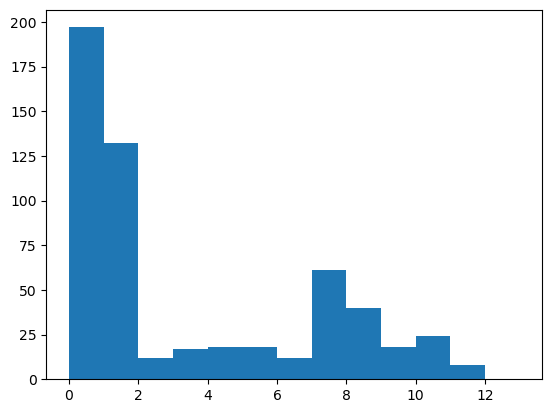

In [23]:
bins = range(0,14,1)

plt.hist(df_single_pairs[df_single_pairs.UniProtID == 'P03369'].rmsd, bins=bins)

In [24]:
sorted(df_single_pairs[(df_single_pairs.UniProtID == 'P03369') & (df_single_pairs.rmsd > 7)].Docked.unique())

['1B6K_PI5',
 '1B6L_PI4',
 '1B6P_PI7',
 '1D4K_PI8',
 '1D4L_PI9',
 '1KZK_JE2',
 '1MTR_PI6',
 '1Z1H_HBB',
 '1Z1R_HBH',
 '2AID_THK',
 '2QHY_MZ1',
 '2QHZ_MZ2',
 '2QI0_MZ3',
 '2QI1_MZ4',
 '2QI3_MZ5',
 '2QI4_MZ6',
 '2QI5_MZ7',
 '2QI6_MZ8',
 '2QI7_MZ9',
 '3AID_ARQ',
 '3BXR_DRR',
 '3BXS_DRS',
 '3EKV_478',
 '3EL4_ROC',
 '3EL9_DR7',
 '3GI4_K60',
 '3GI5_K62',
 '3GI6_D78',
 '3HAU_2NC',
 '3I7E_DJR',
 '3MXD_K53',
 '3MXE_K54']

In [25]:
df_single_pairs_6 = df_single_pairs[df_single_pairs.Tanimoto_Similarity >= 0.6]
df_single_pairs_7 = df_single_pairs[df_single_pairs.Tanimoto_Similarity >= 0.7]

In [87]:
df_single_pairs_no_P29476 = df_single_pairs[df_single_pairs.UniProtID != 'P29476']
df_single_pairs_6_no_P29476 = df_single_pairs_no_P29476[df_single_pairs_no_P29476.Tanimoto_Similarity >= 0.6]
df_single_pairs_7_no_P29476 = df_single_pairs_no_P29476[df_single_pairs_no_P29476.Tanimoto_Similarity >= 0.7]


In [97]:
# pd.set_option('display.max_rows', None)
# df_single_pairs_6[df_single_pairs_6.rmsd >= 9].sort_values(by='Tanimoto_Similarity', ascending=False)


,UniProtID,Template,Docked,rmsd,sorted_pair,Tanimoto_Similarity
94175,P29476,3NLV_3XA,3NLX_3XB,10.436,"(3NLV_3XA, 3NLX_3XB)",1.000000
80915,P15121,1X97_FIR,3BCJ_FIS,9.057,"(1X97_FIR, 3BCJ_FIS)",1.000000
93585,P29476,4CTP_2IK,4CTQ_S5D,10.188,"(4CTP_2IK, 4CTQ_S5D)",1.000000
106127,P29476,3JWS_JI4,3JX3_JI5,10.617,"(3JWS_JI4, 3JX3_JI5)",1.000000
105607,P29476,3JWV_J14,3JX3_JI5,10.416,"(3JWV_J14, 3JX3_JI5)",1.000000
96155,P29476,3NNY_59R,3NNZ_59W,10.360,"(3NNY_59R, 3NNZ_59W)",1.000000
105500,P29476,3JWU_J11,3JX3_JI5,10.594,"(3JWU_J11, 3JX3_JI5)",1.000000
107102,P29476,3NLM_JRR,3NLK_JSS,10.504,"(3NLK_JSS, 3NLM_JRR)",1.000000
110681,P29476,4CX6_Q16,4LUX_QJ8,10.546,"(4CX6_Q16, 4LUX_QJ8)",1.000000
67349,P03369,2QI4_MZ6,2QI6_MZ8,9.819,"(2QI4_MZ6, 2QI6_MZ8)",0.876712


In [115]:
# pd.reset_option('display.max_rows')

In [116]:
len(df_single_pairs[df_single_pairs.rmsd <= 2])/len(df_single_pairs)

0.48142795834537605

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7037: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


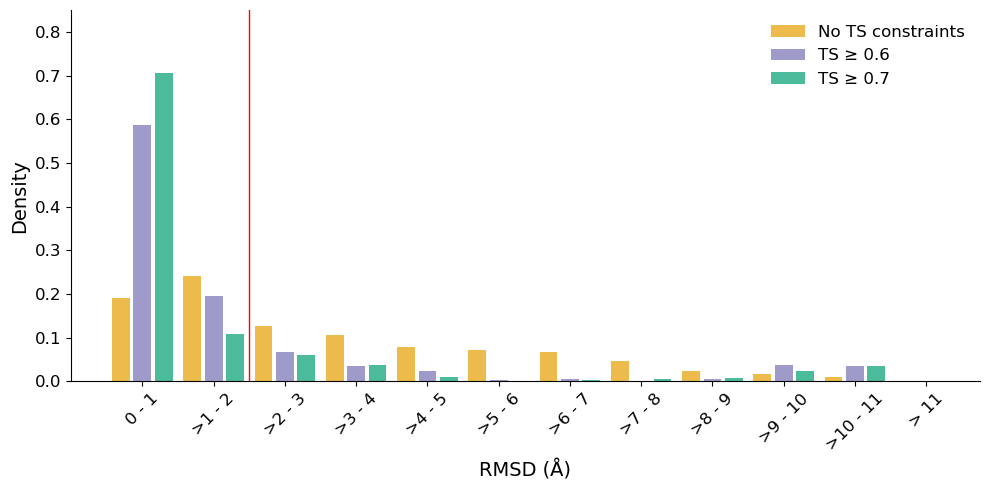

In [114]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
labels = ['No TS constraints', 'TS ≥ 0.6', 'TS ≥ 0.7']
colors = ['#E69F00', '#7570B3', '#009E73']
data = [df_single_pairs.rmsd, df_single_pairs_6.rmsd, df_single_pairs_7.rmsd]

# Define bins with infinite upper bound
bins = list(range(0, 12, 1)) + [float('inf')]
# bin_labels = [f"{bins[i]} - {bins[i+1] - 1 if bins[i+1] == float('inf') else bins[i] + 1}" if bins[i+1] != float('inf') else f"> {bins[i]}" for i in range(len(bins)-1)]

bin_labels = [
    f"{bins[i]} - {bins[i+1]}" if bins[i] == 0 and bins[i+1] != float('inf')
    else f">{bins[i]} - {bins[i+1]}" if bins[i] != 0 and bins[i+1] != float('inf')
    else f"> {bins[i]}"
    for i in range(len(bins)-1)
]

plt.figure(figsize=(10, 5))

# Plot histograms with shifted bins
for i, (d, c) in enumerate(zip(data, colors)):
    # Convert bins to numpy array and handle the shift
    bins_shifted = np.array(bins) - 0.425 + i * 0.3
    plt.hist(d, bins=bins_shifted,
             alpha=0.7, color=c, linewidth=0.3,
             density=True, width=0.25, label=labels[i])

# Adjust x-ticks to be centered between the bar groups
tick_positions = np.arange(len(bin_labels))  # Use index positions for custom labels
plt.xticks(tick_positions, bin_labels, fontsize=12, rotation=45)
plt.axvline(x=1.5, color='red', linestyle='-', linewidth=1)
ax = plt.gca()
for label in ax.get_xticklabels():
    label.set_x(label.get_position()[0])
# Axes and lines
plt.xlabel('RMSD (Å)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(0, 0.85)

# Clean up borders
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    plt.gca().spines[spine].set_color('black')

# Optional legend
plt.legend(fontsize=12, frameon=False)

plt.tight_layout()
plt.savefig('../images/ligand_properties/mcs_rmsd_reference_ligands.png',
            dpi=300, bbox_inches='tight')
plt.show()

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7037: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


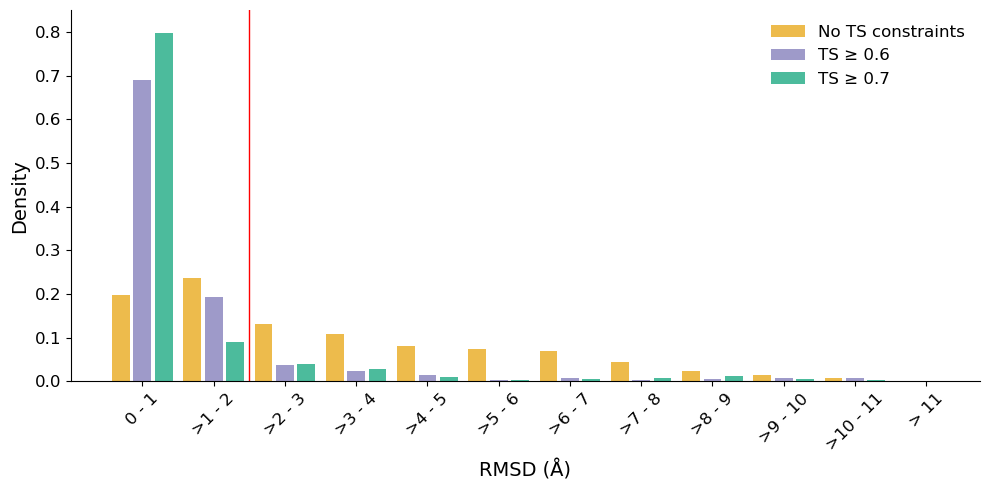

In [113]:
# Prepare data
labels = ['No TS constraints', 'TS ≥ 0.6', 'TS ≥ 0.7']
colors = ['#E69F00', '#7570B3', '#009E73']
data = [df_single_pairs_no_P29476.rmsd,
        df_single_pairs_6_no_P29476.rmsd,
        df_single_pairs_7_no_P29476.rmsd]

# Define bins with infinite upper bound
bins = list(range(0, 12, 1)) + [float('inf')]
# bin_labels = [f"{bins[i]} - {bins[i+1] - 1 if bins[i+1] == float('inf') else bins[i] + 1}" if bins[i+1] != float('inf') else f"> {bins[i]}" for i in range(len(bins)-1)]

bin_labels = [
    f"{bins[i]} - {bins[i+1]}" if bins[i] == 0 and bins[i+1] != float('inf')
    else f">{bins[i]} - {bins[i+1]}" if bins[i] != 0 and bins[i+1] != float('inf')
    else f"> {bins[i]}"
    for i in range(len(bins)-1)
]

plt.figure(figsize=(10, 5))

# Plot histograms with shifted bins
for i, (d, c) in enumerate(zip(data, colors)):
    # Convert bins to numpy array and handle the shift
    bins_shifted = np.array(bins) - 0.425 + i * 0.3
    plt.hist(d, bins=bins_shifted,
             alpha=0.7, color=c, linewidth=0.3,
             density=True, width=0.25, label=labels[i])

# Adjust x-ticks to be centered between the bar groups
tick_positions = np.arange(len(bin_labels))  # Use index positions for custom labels
plt.xticks(tick_positions, bin_labels, fontsize=12, rotation=45)
plt.axvline(x=1.5, color='red', linestyle='-', linewidth=1)
ax = plt.gca()
for label in ax.get_xticklabels():
    label.set_x(label.get_position()[0])
# Axes and lines
plt.xlabel('RMSD (Å)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(0, 0.85)

# Clean up borders
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    plt.gca().spines[spine].set_color('black')

# Optional legend
plt.legend(fontsize=12, frameon=False)

plt.tight_layout()
plt.savefig('../images/ligand_properties/mcs_rmsd_reference_ligands_no_P29476.png',
            dpi=300, bbox_inches='tight')
plt.show()

In [59]:
# pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows')
to_thesis = df_single_pairs_7[df_single_pairs_7.rmsd > 9]
to_thesis['Ligand Pair'] = to_thesis.Template + ' - ' + to_thesis.Docked
to_thesis = to_thesis.drop(columns=['Template', 'Docked', 'sorted_pair'])
len(to_thesis[to_thesis.UniProtID == 'P29476'])

/tmp/ipykernel_1453861/3755501120.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_thesis['Ligand Pair'] = to_thesis.Template + ' - ' + to_thesis.Docked


35

In [112]:
len(df_single_pairs_7.Docked.unique())

413

In [168]:
print(len(df_single_pairs[df_single_pairs.rmsd <= 2])/len(df_single_pairs))
print(len(df_single_pairs_6[df_single_pairs_6.rmsd >= 8])/len(df_single_pairs_6))
print(len(df_single_pairs_7[df_single_pairs_7.rmsd >= 8])/len(df_single_pairs_7))

0.4803944752445764
0.07970529135967849
0.06485671191553545


In [100]:
print(len(df_single_pairs_no_P29476[df_single_pairs_no_P29476.rmsd <= 2])/len(df_single_pairs_no_P29476))
print(len(df_single_pairs_6_no_P29476[df_single_pairs_6_no_P29476.rmsd <= 2])/len(df_single_pairs_6_no_P29476))
print(len(df_single_pairs_7_no_P29476[df_single_pairs_7_no_P29476.rmsd <= 2])/len(df_single_pairs_7_no_P29476))

0.4886769837818344
0.8937768240343348
0.8886363636363637


# MCS coverage/TS relationship

In [4]:
astex

,UniProt_ID,PDB,Lig,Smiles_String,Template
0,O14757,3TKH,07S,c1cc(cnc1)c2cnc(s2)Nc3cc(ccn3)N4CCN(CC4)CC(=O)...,3TKH_07S
1,O14757,4HYH,1AM,COc1ccc2c(c1)C(=O)N(C2)c3nc(cs3)C(=O)Nc4cnccc4...,4HYH_1AM
2,O14757,4HYI,1AO,c1ccc2c(c1)cnn2c3nc(cs3)C(=O)Nc4ccccc4N5CCNCC5,4HYI_1AO
3,O14757,4JIK,1KO,c1cc(ccc1c2cn3c(n2)c(cnc3C(=O)N)N[C@H]4CCCNC4)Cl,4JIK_1KO
4,O14757,3OT3,22K,Cn1cc(cn1)c2cnn3c2nc(c(c3N)Br)[C@@H]4CCC[C@@H]...,3OT3_22K
...,...,...,...,...,...
2005,Q8I3X4,1Q1G,MTI,CSC[C@@H]1[C@H]([C@H]([C@@H]([NH2+]1)c2c[nH]c3...,1Q1G_MTI
2006,Q9GPQ4,1HP0,AD3,c1cnc(c2c1n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)C...,1HP0_AD3
2007,Q9GPQ4,3B9G,IMH,c1c(c2c([nH]1)c(ncn2)O)[C@H]3[C@@H]([C@@H]([C@...,3B9G_IMH
2008,Q9GPQ4,3EPX,IMQ,c1cc2cccnc2c(c1)C[N@]3C[C@@H]([C@@H]([C@H]3CO)O)O,3EPX_IMQ


In [13]:
astex['Mol'] = astex['Smiles_String'].apply(Chem.MolFromSmiles)
astex

[18:43:08] Explicit valence for atom # 7 Cl, 5, is greater than permitted
[18:43:08] Explicit valence for atom # 35 O, 2, is greater than permitted


,UniProt_ID,PDB,Lig,Smiles_String,Template,Mol
0,O14757,3TKH,07S,c1cc(cnc1)c2cnc(s2)Nc3cc(ccn3)N4CCN(CC4)CC(=O)...,3TKH_07S,<rdkit.Chem.rdchem.Mol object at 0x73c963c30f90>
1,O14757,4HYH,1AM,COc1ccc2c(c1)C(=O)N(C2)c3nc(cs3)C(=O)Nc4cnccc4...,4HYH_1AM,<rdkit.Chem.rdchem.Mol object at 0x73c963c31000>
2,O14757,4HYI,1AO,c1ccc2c(c1)cnn2c3nc(cs3)C(=O)Nc4ccccc4N5CCNCC5,4HYI_1AO,<rdkit.Chem.rdchem.Mol object at 0x73c963c312a0>
3,O14757,4JIK,1KO,c1cc(ccc1c2cn3c(n2)c(cnc3C(=O)N)N[C@H]4CCCNC4)Cl,4JIK_1KO,<rdkit.Chem.rdchem.Mol object at 0x73c963c31310>
4,O14757,3OT3,22K,Cn1cc(cn1)c2cnn3c2nc(c(c3N)Br)[C@@H]4CCC[C@@H]...,3OT3_22K,<rdkit.Chem.rdchem.Mol object at 0x73c963c31070>
...,...,...,...,...,...,...
2005,Q8I3X4,1Q1G,MTI,CSC[C@@H]1[C@H]([C@H]([C@@H]([NH2+]1)c2c[nH]c3...,1Q1G_MTI,<rdkit.Chem.rdchem.Mol object at 0x73c963c6ff40>
2006,Q9GPQ4,1HP0,AD3,c1cnc(c2c1n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)C...,1HP0_AD3,<rdkit.Chem.rdchem.Mol object at 0x73c963c70040>
2007,Q9GPQ4,3B9G,IMH,c1c(c2c([nH]1)c(ncn2)O)[C@H]3[C@@H]([C@@H]([C@...,3B9G_IMH,<rdkit.Chem.rdchem.Mol object at 0x73c963c700b0>
2008,Q9GPQ4,3EPX,IMQ,c1cc2cccnc2c(c1)C[N@]3C[C@@H]([C@@H]([C@H]3CO)O)O,3EPX_IMQ,<rdkit.Chem.rdchem.Mol object at 0x73c963c70120>


In [15]:
astex = astex.dropna()

In [24]:
from rdkit.Chem import rdFMCS, AllChem, DataStructs
from itertools import combinations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# MCS coverage
def compute_mcs_coverage(mol1, mol2):
    mcs = rdFMCS.FindMCS([mol1, mol2])
    mcs_mol = Chem.MolFromSmarts(mcs.smartsString)

    match1 = mol1.GetSubstructMatches(mcs_mol)
    match2 = mol2.GetSubstructMatches(mcs_mol)

    if not match1 or not match2:
        return 0.0, 0.0

    mcs_atoms = len(match1[0])
    return mcs_atoms / mol1.GetNumAtoms(), mcs_atoms / mol2.GetNumAtoms()

rows = []

uniprot_ids = astex['UniProt_ID'].unique()

for uniprot in uniprot_ids:
    protein_templates = astex[astex['UniProt_ID'] == uniprot]
    template_ids = protein_templates['Template'].tolist()
    
    n = len(template_ids)
    for i in range(n):
        for j in range(i + 1, n):
            t1 = template_ids[i]
            t2 = template_ids[j]
            
            ts = similarity_matrix.loc[t1, t2]
            
            mol1 = protein_templates.loc[protein_templates['Template'] == t1, 'Mol'].iloc[0]
            mol2 = protein_templates.loc[protein_templates['Template'] == t2, 'Mol'].iloc[0]
            
            rows.append({
                'UniProt_ID': uniprot,
                'Template_1': t1,
                'Template_2': t2,
                'Mol_1': mol1,
                'Mol_2': mol2,
                'Tanimoto_Similarity': ts
            })

pairs_df = pd.DataFrame(rows)



In [31]:
# Note: this takes a while to run

for i in tqdm(pairs_df.index, desc="Computing MCS coverage"):
    mol1 = pairs_df.at[i, 'Mol_1']
    mol2 = pairs_df.at[i, 'Mol_2']
    cov1, cov2 = compute_mcs_coverage(mol1, mol2)
    pairs_df.at[i, 'MCS_Coverage_1'] = cov1
    pairs_df.at[i, 'MCS_Coverage_2'] = cov2

Computing MCS coverage: 100%|█████████| 114142/114142 [2:12:41<00:00, 14.34it/s]


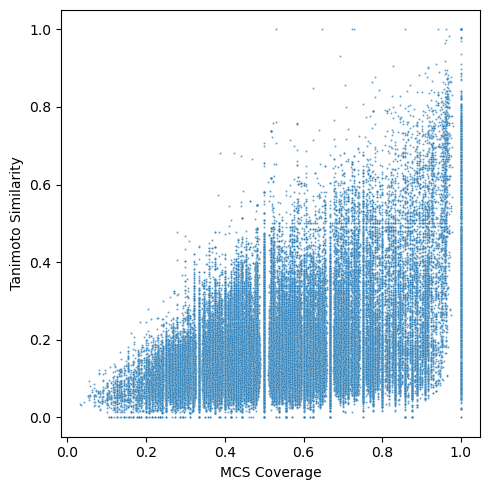

In [51]:
plt.figure(figsize=(5, 5))
sns.scatterplot(
    data=pairs_df,
    x="MCS_Coverage_1",
    y="Tanimoto_Similarity",
    alpha=0.7,
    s=2
)
plt.xlabel("MCS Coverage")
plt.ylabel("Tanimoto Similarity")
plt.tight_layout()
plt.savefig('../images/tanimoto_similarity_mcs_coverage.png', dpi=300)
plt.show()


In [45]:
similarity_matrix

,3TKH_07S,4HYH_1AM,4HYI_1AO,4JIK_1KO,3OT3_22K,2HY0_306,2HXQ_373,2CGU_3A3,2CGW_3C3,2CGX_3D3,...,1W1Y_TYP,1JJT_BDS,1JJE_BYS,6AQS_IM5,1NW4_IMH,1Q1G_MTI,1HP0_AD3,3B9G_IMH,3EPX_IMQ,3EPW_JMQ
3TKH_07S,1.000000,0.163636,0.151515,0.135922,0.067961,0.130000,0.110000,0.109756,0.067416,0.090909,...,0.137931,0.137500,0.144578,0.103093,0.087912,0.082474,0.134831,0.087912,0.147727,0.105263
4HYH_1AM,0.163636,1.000000,0.463415,0.160377,0.094340,0.155340,0.125000,0.141176,0.097826,0.096774,...,0.141304,0.089888,0.086022,0.130000,0.060606,0.088235,0.091837,0.060606,0.114583,0.110000
4HYI_1AO,0.151515,0.463415,1.000000,0.197802,0.108696,0.129032,0.144444,0.077922,0.087500,0.113924,...,0.151899,0.106667,0.129870,0.151163,0.070588,0.065934,0.107143,0.070588,0.148148,0.114943
4JIK_1KO,0.135922,0.160377,0.197802,1.000000,0.166667,0.148936,0.115789,0.088608,0.071429,0.151899,...,0.132530,0.088608,0.084337,0.120879,0.093023,0.086957,0.103448,0.093023,0.116279,0.111111
3OT3_22K,0.067961,0.094340,0.108696,0.166667,1.000000,0.109890,0.100000,0.039474,0.106667,0.076923,...,0.087500,0.039474,0.037500,0.104651,0.048193,0.056818,0.098765,0.048193,0.085366,0.068966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1Q1G_MTI,0.082474,0.088235,0.065934,0.086957,0.056818,0.103448,0.093023,0.104478,0.068493,0.144928,...,0.108108,0.072464,0.068493,0.232877,0.281250,1.000000,0.135135,0.281250,0.135135,0.375000
1HP0_AD3,0.134831,0.091837,0.107143,0.103448,0.098765,0.069767,0.084337,0.093750,0.104478,0.136364,...,0.098592,0.111111,0.104478,0.178082,0.181818,0.135135,1.000000,0.181818,0.230769,0.183099
3B9G_IMH,0.087912,0.060606,0.070588,0.093023,0.048193,0.084337,0.086420,0.096774,0.058824,0.158730,...,0.101449,0.062500,0.058824,0.217391,1.000000,0.281250,0.181818,1.000000,0.181818,0.261538
3EPX_IMQ,0.147727,0.114583,0.148148,0.116279,0.085366,0.135802,0.153846,0.111111,0.072464,0.102941,...,0.114286,0.111111,0.121212,0.264706,0.181818,0.135135,0.230769,0.181818,1.000000,0.473684


In [ ]:
# plot_df = pd.concat([
#     pairs_df.rename(columns={"MCS_Coverage_1": "Coverage"})[["UniProt_ID", "Template_1", "Template_2", "Tanimoto_Similarity", "Coverage"]],
#     pairs_df.rename(columns={"MCS_Coverage_2": "Coverage"})[["UniProt_ID", "Template_1", "Template_2", "Tanimoto_Similarity", "Coverage"]]
# ], ignore_index=True)